# HPO result visualizations

In [1]:
import optuna
import sshtunnel
import os
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import numpy as np
from pathlib import Path
import pandas as pd
from pprint import pprint

from mawkutils.experiments import evaluate_generalization
from mawkutils.data import DBManager
from visualize_performance import show_error_trajectories_4_diss
from mawkutils.render import prettify


IMG_PATH = Path().cwd().parent / 'notebooks' / 'img'
fig_scale = 1.0  # 1.875


/home/wk/dev/tools/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TNN HPO

In [2]:
STUDY_NAME = 'study_4_diss_reduce_lr_tnn'
study_names = ['study_4_diss_tnn', "study_4_diss_reduce_lr_tnn"]
PSQLDB_NAME = 'optuna'

In [3]:

with open(f'{os.getenv("HOME")}/creds/optuna_psql', 'r') as f:
    optuna_creds = ':'.join([s.strip() for s in f.readlines()])
server_name = 'lea38'
tun_cfg = dict(remote_bind_address=('localhost', 5432))
tunnel = sshtunnel.SSHTunnelForwarder(server_name, **tun_cfg)
study_df_l_tnn = []
with tunnel:
    storage_str = f'postgresql://{optuna_creds}@localhost:{tunnel.local_bind_port}/{PSQLDB_NAME}'
    for stud in study_names:
        loaded_study = optuna.create_study(storage=storage_str, study_name=stud,
                                           load_if_exists=True, direction="minimize")
        study_df = loaded_study.trials_dataframe()
        # TNN specific correction (due to bug in calc_metrics)
        study_df.value *= 5
        if 'reduce_lr' in stud:
            # this study was continued with correct code as of trial no 3915
            study_df.loc[study_df.number >= 3915, 'value'] /= 5
        study_df_l_tnn.append(study_df)


[I 2023-08-25 11:34:01,481] Using an existing study with name 'study_4_diss_tnn' instead of creating a new one.
[I 2023-08-25 11:34:36,834] Using an existing study with name 'study_4_diss_reduce_lr_tnn' instead of creating a new one.


In [4]:
# specific small tnn with good performance
stud = study_df_l_tnn[-1]
stud.query("number == 34385").T

34385
number                                                               34385
value                                                             4.078759
datetime_start                                  2023-03-01 10:31:39.118599
datetime_complete                               2023-03-01 11:16:22.638774
duration                                            0 days 00:44:43.520175
params_act_g_layer_0                                                  relu
params_act_g_layer_1                                                   NaN
params_act_g_layer_2                                                   NaN
params_act_p_layer_0                                                  tanh
params_act_p_layer_1                                                   NaN
params_act_p_layer_2                                                   NaN
params_chunk_size                                                   5870.0
params_fe_extension                                                  basic
params_g_out_act                                                biased_elu
params_inital_lr                                                  0.017895
params_inv_caps_init_gauss_mean_pm                               -2.695737
params_inv_caps_init_gauss_mean_stator_tooth                      -8.75059
params_inv_caps_init_gauss_mean_stator_winding                   -9.674542
params_inv_caps_init_gauss_mean_stator_yoke                     -16.697096
params_n_batches                                                       4.0
params_n_g_layers                                                      1.0
params_n_p_layers                                                      1.0
params_n_units_g_layer_0                                               2.0
params_n_units_g_layer_1                                               NaN
params_n_units_g_layer_2                                               NaN
params_n_units_p_layer_0                                               2.0
params_n_units_p_layer_1                                               NaN
params_n_units_p_layer_2                                               NaN
params_optimizer                                                   rmsprop
params_p_out_act                                                   sigmoid
params_tbptt_len                                                     558.0
state                                                             COMPLETE

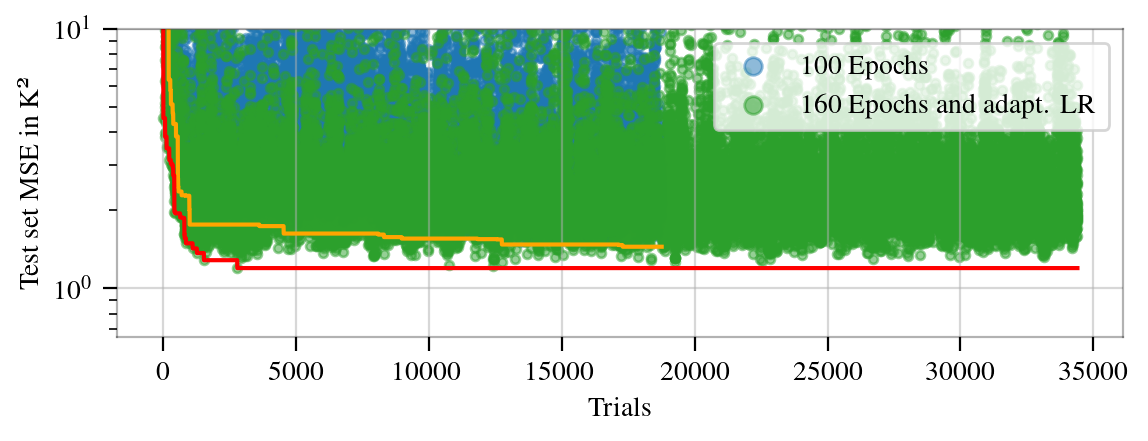

In [5]:

fig = plt.figure(figsize=(6.49*fig_scale, 2*fig_scale), dpi=200)
successful_trials_df_tnn_l = [study_df.query("state == 'COMPLETE'") for study_df in study_df_l_tnn]
plt.scatter(successful_trials_df_tnn_l[0].number,
            successful_trials_df_tnn_l[0].value, label='100 Epochs', alpha=0.5, s=10)
plt.scatter(successful_trials_df_tnn_l[1].number, successful_trials_df_tnn_l[1].value,
            label='160 Epochs and adapt. LR', alpha=0.5, c='tab:green', s=10)
plt.plot(successful_trials_df_tnn_l[0].number, np.minimum.accumulate(
    successful_trials_df_tnn_l[0].value), color='orange')
plt.plot(successful_trials_df_tnn_l[1].number, np.minimum.accumulate(successful_trials_df_tnn_l[1].value), color='red')

plt.xlabel("Trials")
plt.ylabel("Test set MSE in K²")
plt.yscale("log")
plt.ylim(None, 1e1)
# plt.xscale('log')
plt.grid(alpha=0.5)
plt.legend(frameon=True, markerscale=2)
prettify(plt.gca())
#plt.title("Objective Trend")


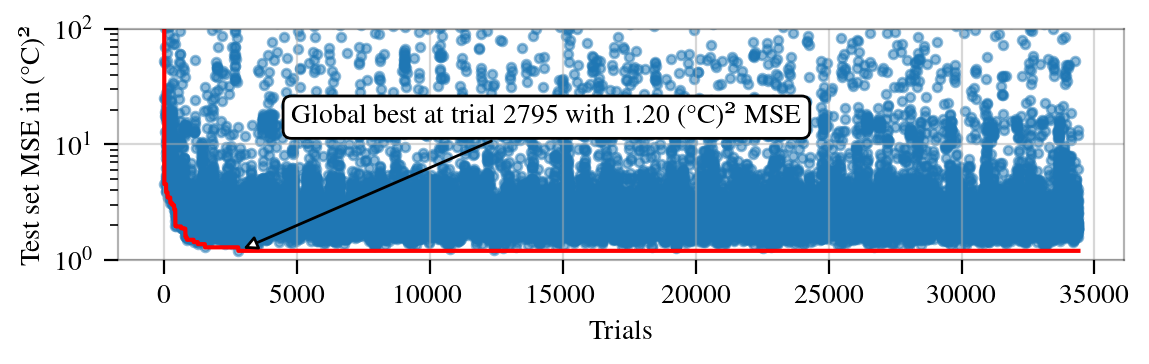

In [6]:
fig = plt.figure(figsize=(6.49*fig_scale, 1.5*fig_scale), dpi=200)
study_to_show = successful_trials_df_tnn_l[1]
plt.scatter(study_to_show.number,
            study_to_show.value, label='100 Epochs', alpha=0.5, s=10)

plt.plot(study_to_show.number, np.minimum.accumulate(study_to_show.value), color='red')

global_best_num = study_to_show.loc[
    np.minimum.accumulate(study_to_show.value) <= np.minimum.accumulate(study_to_show.value).iloc[-1], 'number'].iloc[0]
global_best_val = study_to_show.query('number == @global_best_num').loc[:, 'value'].iloc[0]
plt.xlabel("Trials")
plt.ylabel("Test set MSE in (°C)²")
plt.yscale("log")
plt.ylim(1, 1e2)
# plt.xscale('log')
plt.annotate(f"Global best at trial {global_best_num} with "
             f"{global_best_val:.2f} (°C)² MSE",
             (global_best_num, global_best_val), 
             (global_best_num + 2000, 15), 
             bbox=dict(boxstyle="round", fc="w"),
             arrowprops=dict(arrowstyle="-|>", fc="w"))
plt.grid(alpha=0.5)
prettify(plt.gca())
#plt.title("Objective Trend")
fig.savefig(IMG_PATH / "diss_hpo_trend_tnn.jpg", dpi=300, bbox_inches="tight")

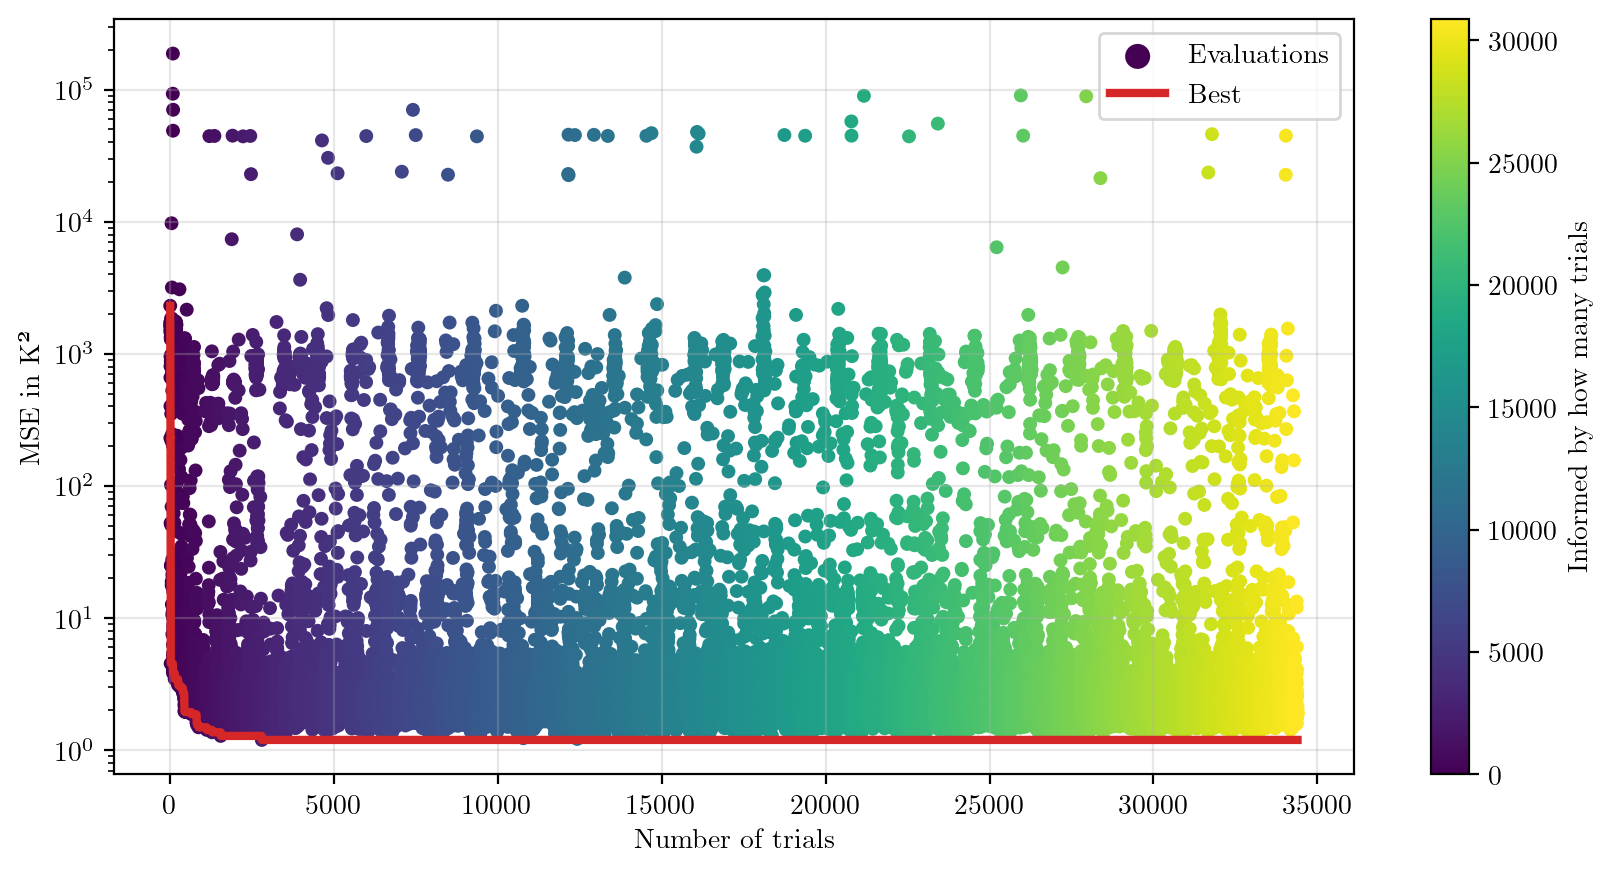

In [7]:
# custom opt history
trials = [dict(value=t.value, completed=t.datetime_complete, number=t.number, started=t.datetime_start)
          for _, t in successful_trials_df_tnn_l[1].iterrows()]
df = (pd.DataFrame(trials, columns=['number', 'value', 'completed', 'started'])
        .assign(informed_by_n=lambda x: x.started.transform(lambda y: np.sum(y > x.completed)))
        .sort_values(by='number'))
fig = plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(df.number, df.value, c=df.informed_by_n, cmap='viridis', label='Evaluations', s=16)
plt.yscale('log')
cb = plt.colorbar()
# cb.set_ticklabels(np.round(len(df)*cb.get_ticks()).astype(int))
cb.set_label('Informed by how many trials')

plt.plot(df.number, df.value.cummin(), color='tab:red', lw=3, label='Best')
#plt.ylim(0.8, None)
plt.xlabel('Number of trials')
plt.ylabel('MSE in K²')
plt.legend(frameon=True, markerscale=2)


In [8]:
successful_trials_df_tnn_l[-1].sort_values("value")


number          value             datetime_start  \
2795     2795       1.197484 2023-01-03 04:17:38.356134   
12419   12419       1.218597 2023-02-22 01:15:26.986901   
10774   10774       1.234075 2023-02-21 11:32:45.462825   
12749   12749       1.266493 2023-02-22 03:06:27.096152   
19277   19277       1.268437 2023-02-24 01:32:30.378612   
...       ...            ...                        ...   
27950   27950   89078.849223 2023-02-26 22:46:20.931050   
21167   21167   89784.951424 2023-02-24 15:20:18.623512   
25956   25956   90420.278693 2023-02-26 09:04:21.635729   
79         79   93149.909831 2023-01-01 14:29:07.350581   
81         81  187516.360880 2023-01-01 14:30:54.693986   

               datetime_complete               duration params_act_g_layer_0  \
2795  2023-01-03 04:53:25.458635 0 days 00:35:47.102501                 relu   
12419 2023-02-22 02:00:05.455132 0 days 00:44:38.468231                 relu   
10774 2023-02-21 12:09:05.389335 0 days 00:36:19.926510              sigmoid   
12749 2023-02-22 03:54:57.588548 0 days 00:48:30.492396                 relu   
19277 2023-02-24 02:07:57.987264 0 days 00:35:27.608652                 relu   
...                          ...                    ...                  ...   
27950 2023-02-27 00:01:36.229155 0 days 01:15:15.298105                 relu   
21167 2023-02-24 16:44:20.504903 0 days 01:24:01.881391                sinus   
25956 2023-02-26 09:39:54.053298 0 days 00:35:32.417569                 relu   
79    2023-01-01 15:00:40.905741 0 days 00:31:33.555160                  NaN   
81    2023-01-01 15:04:00.607762 0 days 00:33:05.913776                  NaN   

      params_act_g_layer_1 params_act_g_layer_2 params_act_p_layer_0  \
2795                   NaN                  NaN                 tanh   
12419                  gcu                  NaN                 tanh   
10774                  NaN                  NaN                 relu   
12749                  NaN                  NaN                sinus   
19277                  NaN                  NaN                 tanh   
...                    ...                  ...                  ...   
27950                  NaN                  NaN                 tanh   
21167              sigmoid                  NaN                 tanh   
25956                  NaN                  NaN                 tanh   
79                     NaN                  NaN                  gcu   
81                     NaN                  NaN                  gcu   

      params_act_p_layer_1  ... params_n_units_g_layer_0  \
2795                   NaN  ...                     62.0   
12419                  NaN  ...                     62.0   
10774                  NaN  ...                     61.0   
12749                  NaN  ...                     61.0   
19277                  NaN  ...                     58.0   
...                    ...  ...                      ...   
27950                  NaN  ...                     61.0   
21167                  NaN  ...                     54.0   
25956                  NaN  ...                     63.0   
79                     NaN  ...                      NaN   
81                     gcu  ...                      NaN   

       params_n_units_g_layer_1 params_n_units_g_layer_2  \
2795                        NaN                      NaN   
12419                      59.0                      NaN   
10774                       NaN                      NaN   
12749                       NaN                      NaN   
19277                       NaN                      NaN   
...                         ...                      ...   
27950                       NaN                      NaN   
21167                      25.0                      NaN   
25956                       NaN                      NaN   
79                          NaN                      NaN   
81                          NaN                      NaN   

      params_n_units_p_layer_0

In [9]:
pprint(successful_trials_df_tnn_l[-1].sort_values("value").iloc[0, :].to_dict())

{'datetime_complete': Timestamp('2023-01-03 04:53:25.458635'),
 'datetime_start': Timestamp('2023-01-03 04:17:38.356134'),
 'duration': Timedelta('0 days 00:35:47.102501'),
 'number': 2795,
 'params_act_g_layer_0': 'relu',
 'params_act_g_layer_1': nan,
 'params_act_g_layer_2': nan,
 'params_act_p_layer_0': 'tanh',
 'params_act_p_layer_1': nan,
 'params_act_p_layer_2': nan,
 'params_chunk_size': 4983.0,
 'params_fe_extension': 'basic',
 'params_g_out_act': 'biased_elu',
 'params_inital_lr': 0.006719889598981551,
 'params_inv_caps_init_gauss_mean_pm': -0.9924084465296653,
 'params_inv_caps_init_gauss_mean_stator_tooth': -10.604968666986796,
 'params_inv_caps_init_gauss_mean_stator_winding': -9.353242688198408,
 'params_inv_caps_init_gauss_mean_stator_yoke': -15.74130915948338,
 'params_n_batches': 4.0,
 'params_n_g_layers': 1.0,
 'params_n_p_layers': 1.0,
 'params_n_units_g_layer_0': 62.0,
 'params_n_units_g_layer_1': nan,
 'params_n_units_g_layer_2': nan,
 'params_n_units_p_layer_0': 18

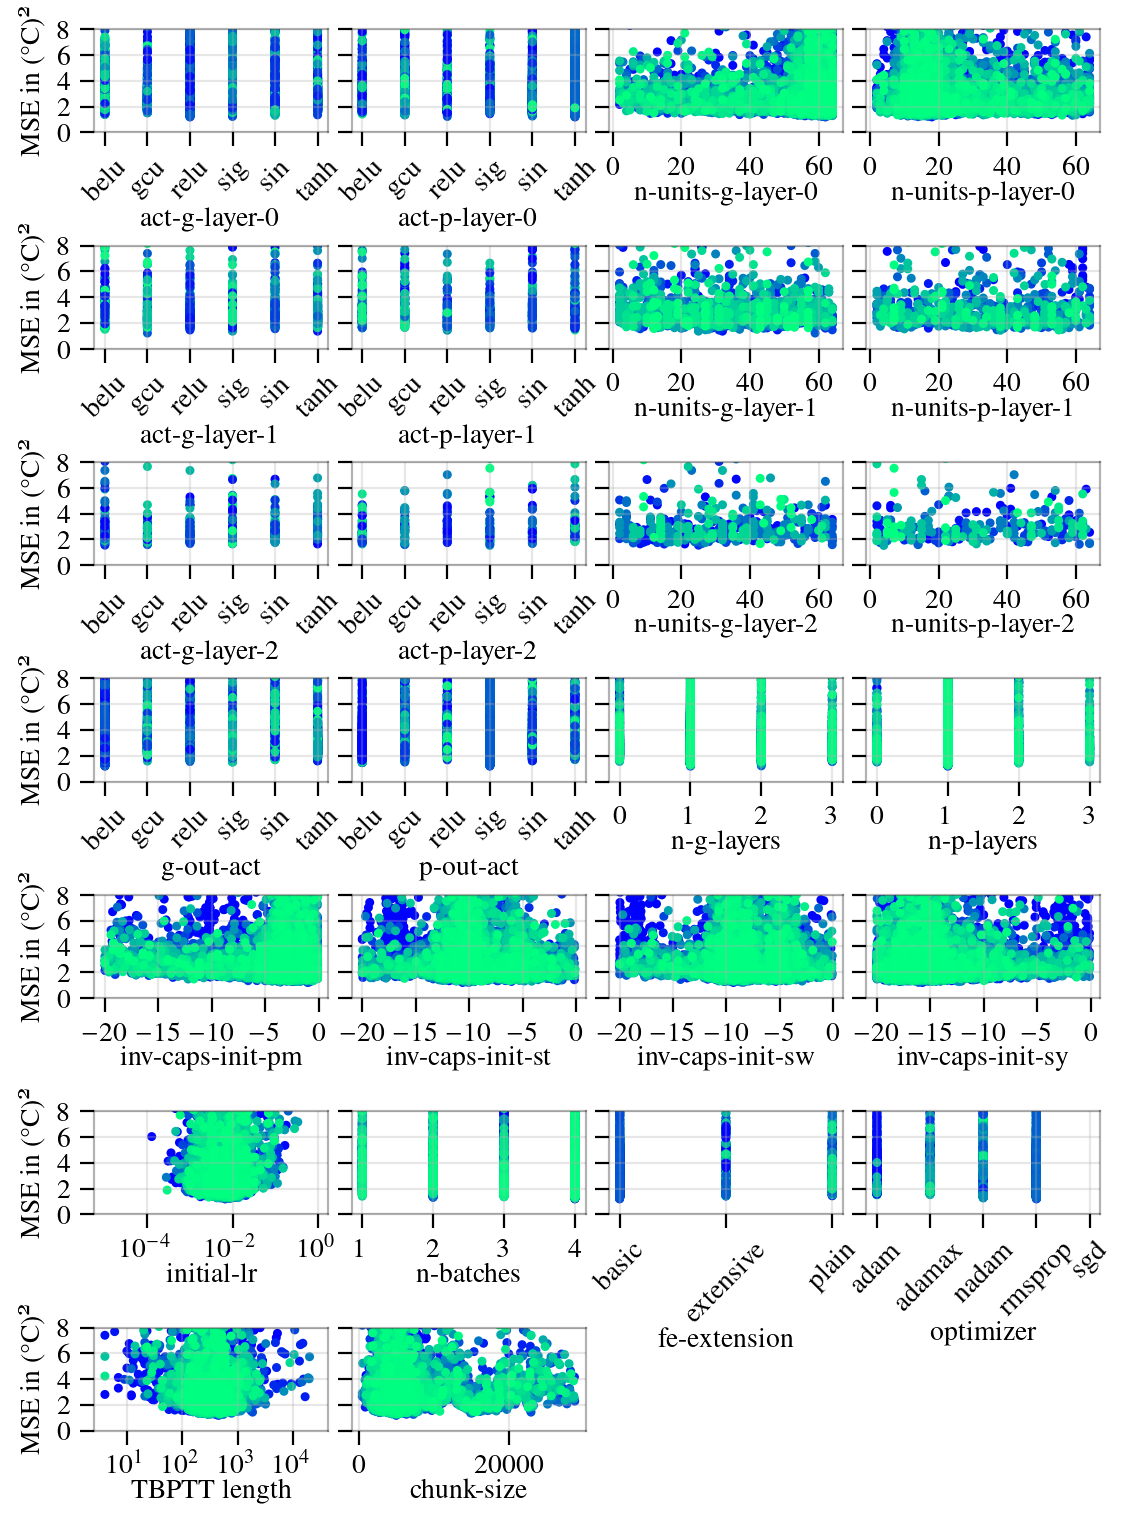

In [8]:
params = [c for c in study_to_show if c not in (
    "number", "value", "datetime_start", "datetime_complete", "state", "duration")]
custom_params = [
    'act_g_layer_0', 'act_p_layer_0', 'n_units_g_layer_0', 'n_units_p_layer_0',
    'act_g_layer_1', 'act_p_layer_1', 'n_units_g_layer_1', 'n_units_p_layer_1',
    'act_g_layer_2', 'act_p_layer_2', 'n_units_g_layer_2', 'n_units_p_layer_2',
    'g_out_act', 'p_out_act', 'n_g_layers', 'n_p_layers', 
    'inv_caps_init_gauss_mean_pm', 'inv_caps_init_gauss_mean_stator_tooth', 
    'inv_caps_init_gauss_mean_stator_winding', 'inv_caps_init_gauss_mean_stator_yoke',
    'inital_lr', 'n_batches','fe_extension',
    'optimizer', 'tbptt_len', 'chunk_size', 
]
custom_params = ['params_'+p for p in custom_params]
assert len(set(params).difference(set(custom_params))) == 0, f"{len(set(params).difference(set(custom_params)))} != 0"
ncols = 4
nrows = np.ceil(len(params) / ncols).astype(int)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=200,
                         figsize=(6.49*fig_scale, 1.3*nrows*fig_scale), sharey=True, sharex=False)
#successful_trials_df = successful_trials_df.query("value < 150")
for ax, param in zip(axes.flatten(), custom_params):
    visible_dots = study_to_show.loc[:, [param, "value", "number"]].dropna()
    if visible_dots.loc[:, param].dtype == object:
        # for latex
        visible_dots.loc[:, param] = (visible_dots.loc[:, param].str.replace('_', '-')
                                                  .str.replace('biased-', 'b')
                                                  .str.replace('sigmoid', 'sig')
                                                  .str.replace('sinus', 'sin'))
        visible_dots = visible_dots.sort_values(param)
    ax.scatter(visible_dots.loc[:, param], visible_dots.loc[:, "value"],
               c=visible_dots.number, cmap='winter', label=None, s=5)
    #ax.set_yscale("log")
    ax.set_ylim(0, 8)
    ax.set_yticks(range(0,10,2))
    ax.set_xlabel(param.replace('params_', '').replace("_", "-")
                  .replace('inv-caps-init-gauss-mean', 'inv-caps-init')
                  .replace("stator-winding", "sw").replace("stator-tooth", "st").replace("stator-yoke", "sy")
                  .replace('inital', 'initial')
                  .replace('tbptt-len', 'TBPTT length'),
                  labelpad=0.1
                  )

    if 'inital' in param:
        ax.set_xscale('log')
        ax.set_xticks(10.0**np.arange(-4, 1, 2))
    if 'tbptt' in param:
        ax.set_xscale('log')
        ax.set_xticks(10.0**np.arange(1, 5))
    elif 'optimizer' in param or 'act' in param or 'extension' in param:
        ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    elif 'layers' in param:
        ax.set_xticks(np.arange(4))
    elif 'batches' in param:
        ax.set_xticks(np.arange(1, 5))
    elif 'units' in param:
        ax.set_xticks([0,20, 40, 60])
    elif 'caps' in param:
        ax.set_xticks(list(np.arange(-20, 5, 5)))
    if ax in [axes[i, 0] for i in range(nrows)]:
        ax.set_ylabel('MSE in (°C)²')
    prettify(ax)

axes[-1, -1].axis('off')
axes[-1, -2].axis('off')
fig.subplots_adjust(hspace=1.1, wspace=0.1,)
# fig.tight_layout()
fig.savefig(IMG_PATH / "diss_hpo_dist_tnn.jpg", dpi=300, bbox_inches="tight")


## Generalization

In [11]:
# generalization
stud_name = study_names[-1]
meta_info = DBManager.query(f"SELECT experiment_id, seed, mse, l_infty_under, l_infty_over, model_size, model_tag FROM trials as t "
                            f"LEFT JOIN experiments as e ON t.experiment_id = e.id "
                            f"where comment ilike '%{stud_name[:-4]}%' "
                            f"and model_tag = 'tnn'"
                            f"ORDER BY t.mse ASC;")
best_models_tnn = meta_info.iloc[:5, :]
best_models_tnn


Test ssh tunnel..ok


experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          84131     1  0.773041      -4.118918      4.766145        2033   
1          28214     0  0.846851      -3.828823      4.980471        1812   
2          67440     4  0.858587      -4.789726      4.834011        1967   
3          82577     8  0.859238      -4.319512      4.635611        1808   
4          31173     0  0.859973      -3.405189      5.099299        2148   

  model_tag  
0       tnn  
1       tnn  
2       tnn  
3       tnn  
4       tnn

In [12]:
top_five = {}
best_models_tnn.loc[:, ['mse_gen', 'l_infty_gen']] = 0
for i in range(5):
    print("model", i)
    exp_info = best_models_tnn.iloc[i, :]
    print(f"Determine generalization capability of {exp_info.experiment_id} seed {exp_info.seed} "
          f"[{exp_info.model_size} params] (test set was {exp_info.mse} K²):")
    preds_tnn, ds_tnn, metrics, _ = evaluate_generalization(int(exp_info.experiment_id), int(exp_info.seed), 0)
    best_models_tnn.at[i, 'mse_gen'] = metrics['mse']
    best_models_tnn.at[i, 'l_infty_gen'] = metrics['l_infty']
    top_five[(exp_info.experiment_id, exp_info.seed)] = (preds_tnn, ds_tnn, metrics['mse'], metrics['l_infty'])


model 0
Determine generalization capability of 84131 seed 1 [2033 params] (test set was 0.7730407 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 8.335099411985809,
 'l_infty_over': 5.514402382153776,
 'l_infty_under': -8.335099411985809,
 'mae': 0.917278939246291,
 'mse': 1.5911145418240737,
 'r2': 0.9950662394033473}
model 1
Determine generalization capability of 28214 seed 0 [1812 params] (test set was 0.8468512 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 6.778267813703948,
 'l_infty_over': 5.234701626080778,
 'l_infty_under': -6.778267813703948,
 'mae': 0.8659302802810372,
 'mse': 1.2821234742033791,
 'r2': 0.9961496385075115}
model 2
Determine generalization capability of 67440 seed 4 [1967 params] (test set was 0.85858715 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 8.692916487107738,
 'l_infty_over': 5.935412945809546,
 'l_infty_under': -8.692916487107738,


Lowest worst case for 82577 seed 8 at MSE = 1.34 K² and e_max = 6.71 K


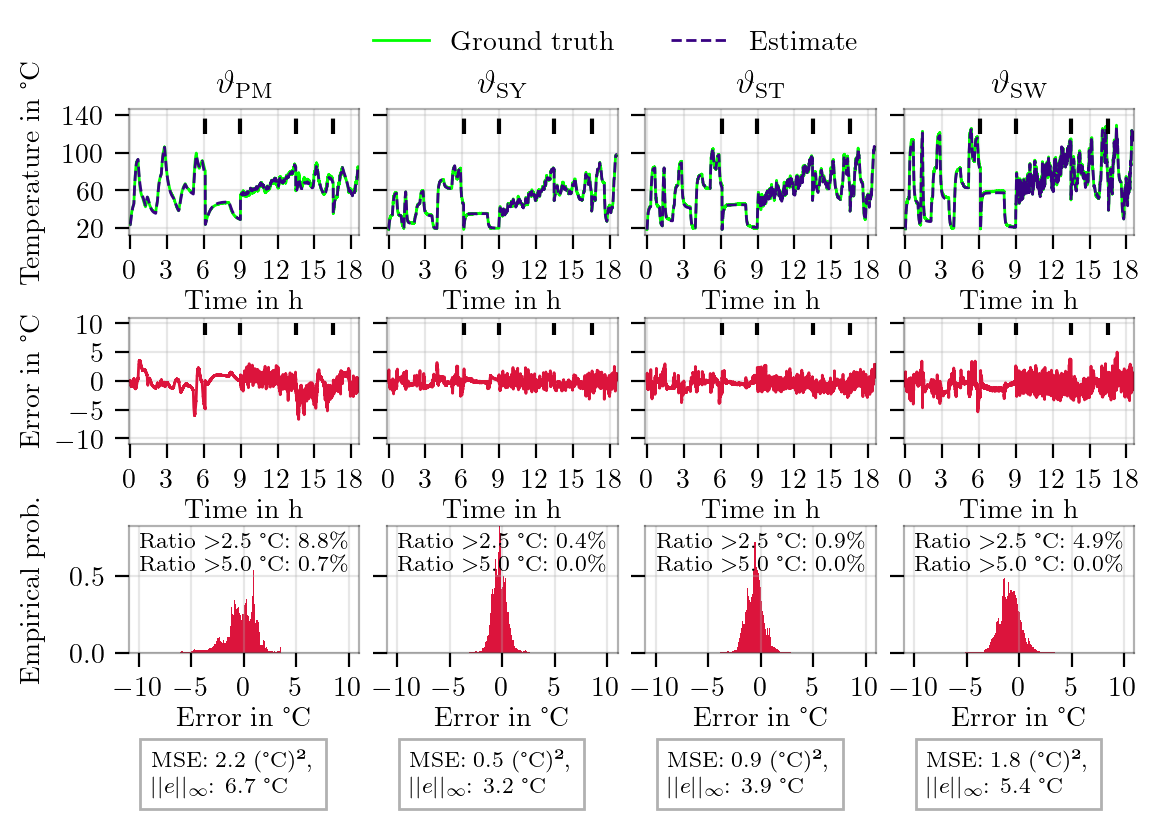

In [13]:
(expid, seed), (preds_tnn, ds_tnn, mse, worst_case) = min(top_five.items(), key=lambda v: v[1][-1])
print(f"Lowest worst case for {expid} seed {seed} at MSE = {mse:.2f} K² and e_max = {worst_case:.2f} K")
fig = show_error_trajectories_4_diss(preds_tnn, dataset=ds_tnn)

fig.savefig(IMG_PATH / "diss_hpo_perf_tnn.jpg", dpi=300, bbox_inches="tight")


# TCN HPO

In [9]:
STUDY_NAME = 'study_4_diss_tcn'
# study_3_4_diss_tcn is unfortunately a mix of study 1 and 4, drop it
study_names = [STUDY_NAME, 'study_2_4_diss_tcn', 'study_4_4_diss_tcn']
PSQLDB_NAME = 'optuna'
with open(f'{os.getenv("HOME")}/creds/optuna_psql', 'r') as f:
    optuna_creds = ':'.join([s.strip() for s in f.readlines()])
server_name = 'lea38'
tun_cfg = dict(remote_bind_address=('localhost', 5432))
tunnel = sshtunnel.SSHTunnelForwarder(server_name, **tun_cfg)
study_df_tcn_l = []
with tunnel:
    storage_str = f'postgresql://{optuna_creds}@localhost:{tunnel.local_bind_port}/{PSQLDB_NAME}'
    for stud in study_names:
        loaded_study = optuna.create_study(storage=storage_str, study_name=stud,
                                           load_if_exists=True, direction="minimize")
        study_df = loaded_study.trials_dataframe()
        study_df_tcn_l.append(study_df)


[I 2023-08-25 11:45:39,539] Using an existing study with name 'study_4_diss_tcn' instead of creating a new one.
[I 2023-08-25 11:45:49,709] Using an existing study with name 'study_2_4_diss_tcn' instead of creating a new one.
[I 2023-08-25 11:45:59,435] Using an existing study with name 'study_4_4_diss_tcn' instead of creating a new one.


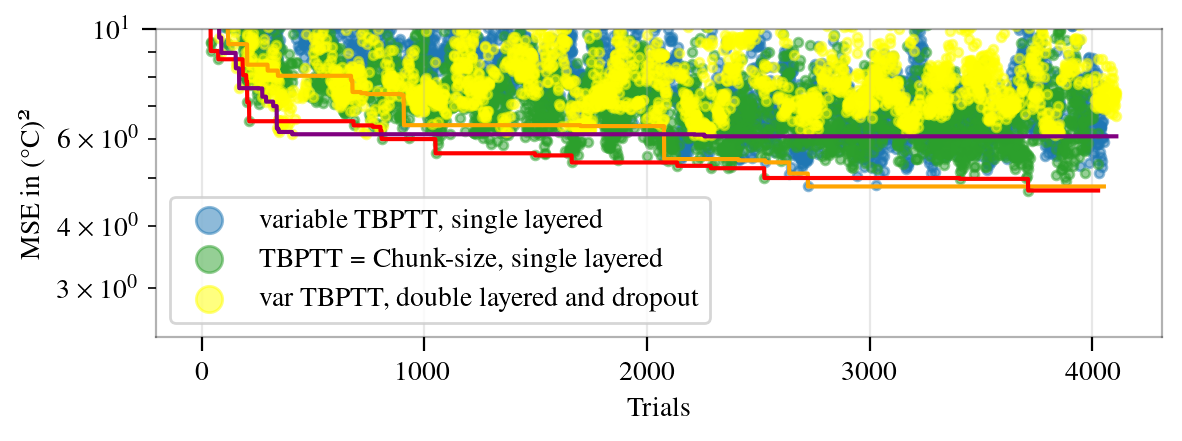

In [17]:
# opt trends
fig = plt.figure(figsize=(6.49*fig_scale, 2*fig_scale), dpi=200)
successful_trials_df_l = [study_df.query("state == 'COMPLETE'") for study_df in study_df_tcn_l]
plt.scatter(successful_trials_df_l[0].number.iloc[:4000], successful_trials_df_l[0].value.iloc[:4000],
            label='variable TBPTT, single layered', alpha=0.5, s=10)
plt.scatter(successful_trials_df_l[1].number.iloc[:4000], successful_trials_df_l[1].value.iloc[:4000],
            label='TBPTT = Chunk-size, single layered', alpha=0.5, c='tab:green', s=10)
plt.scatter(successful_trials_df_l[2].number.iloc[:4000], successful_trials_df_l[2].value.iloc[:4000],
            label='var TBPTT, double layered and dropout', alpha=0.5, c='yellow', s=10)
plt.plot(successful_trials_df_l[0].number.iloc[:4000], np.minimum.accumulate(
    successful_trials_df_l[0].value.iloc[:4000]), color='orange')
plt.plot(successful_trials_df_l[1].number.iloc[:4000], np.minimum.accumulate(
    successful_trials_df_l[1].value.iloc[:4000]), color='red')
plt.plot(successful_trials_df_l[2].number.iloc[:4000], np.minimum.accumulate(
    successful_trials_df_l[2].value.iloc[:4000]), color='purple')
plt.xlabel("Trials")
plt.ylabel("MSE in (°C)²")
plt.yscale("log")
plt.ylim(None, 1e1)
prettify(plt.gca())
plt.legend(frameon=True, markerscale=3)
#plt.title("Objective Trend")
fig.savefig(IMG_PATH / "diss_hpo_trend_tcn.jpg", dpi=300, bbox_inches="tight")


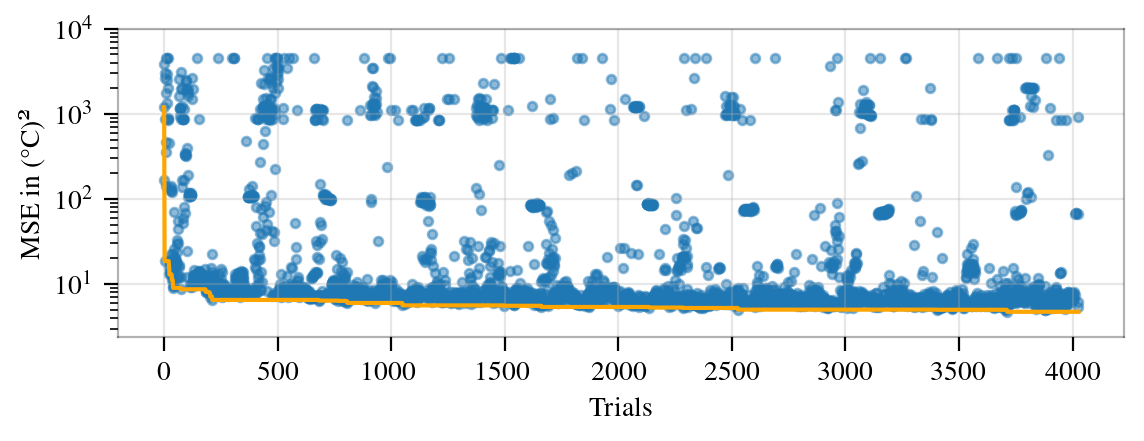

In [18]:
# opt trend
study_df_tcn = study_df_tcn_l[1]
study_name_tcn = study_names[1][:-4]
fig = plt.figure(figsize=(6.49*fig_scale, 2*fig_scale))
successful_trials_df_tcn = study_df_tcn.query("state == 'COMPLETE'")
plt.scatter(successful_trials_df_tcn.number, successful_trials_df_tcn.value, alpha=0.5, s=10)
plt.plot(successful_trials_df_tcn.number, np.minimum.accumulate(successful_trials_df_tcn.value), color='orange')

plt.xlabel("Trials")
plt.ylabel("MSE in (°C)²")
plt.yscale("log")
plt.ylim(None, 1e4)
plt.grid(alpha=.3)
prettify(plt.gca())

# plt.xscale('log')
#plt.legend(frameon=True, markerscale=3)
#plt.title("Objective trend TCN")


In [17]:
successful_trials_df_tcn.sort_values("value")


number         value             datetime_start  \
3712    3712  4.723586e+00 2023-02-10 08:39:30.104356   
3880    3880  4.942067e+00 2023-02-10 13:32:59.174976   
3404    3404  4.986428e+00 2023-02-10 01:37:10.573527   
2527    2527  5.005500e+00 2023-02-09 06:58:37.810785   
3703    3703  5.016744e+00 2023-02-10 08:31:15.191100   
...      ...           ...                        ...   
1201    1201  1.885465e+06 2023-02-08 08:34:17.140026   
1011    1011  1.885465e+06 2023-02-08 04:02:13.751897   
3715    3715  2.820556e+06 2023-02-10 08:42:34.328146   
3738    3738  2.820556e+06 2023-02-10 09:19:39.617390   
2967    2967  3.748779e+06 2023-02-09 15:53:47.959732   

              datetime_complete               duration  params_chunk_size  \
3712 2023-02-10 10:45:00.562630 0 days 02:05:30.458274              19051   
3880 2023-02-10 15:05:51.663415 0 days 01:32:52.488439              19064   
3404 2023-02-10 02:40:11.315236 0 days 01:03:00.741709              17693   
2527 2023-02-09 08:13:56.609115 0 days 01:15:18.798330              18475   
3703 2023-02-10 10:37:19.226356 0 days 02:06:04.035256              19067   
...                         ...                    ...                ...   
1201 2023-02-08 10:06:59.584076 0 days 01:32:42.444050              21380   
1011 2023-02-08 05:31:18.807780 0 days 01:29:05.055883              22095   
3715 2023-02-10 11:02:26.177333 0 days 02:19:51.849187              20078   
3738 2023-02-10 10:59:51.929998 0 days 01:40:12.312608              20252   
2967 2023-02-09 17:19:21.706696 0 days 01:25:33.746964              17533   

      params_has_ewma  params_inital_lr  params_is_residual  \
3712             True          0.001176                True   
3880             True          0.000900                True   
3404             True          0.000811               False   
2527             True          0.001201               False   
3703             True          0.001155                True   
...               ...               ...                 ...   
1201             True          0.830885                True   
1011             True          0.124968                True   
3715             True          0.694169                True   
3738             True          0.596290                True   
2967             True          0.294478                True   

      params_kernel_size_layer_0  params_kernel_size_layer_1  \
3712                         7.0                         7.0   
3880                         7.0                         3.0   
3404                         7.0                         7.0   
2527                         7.0                         7.0   
3703                         7.0                         7.0   
...                          ...                         ...   
1201                         5.0                         5.0   
1011                         4.0                         2.0   
3715                         7.0                         7.0   
3738                         7.0                         7.0   
2967                         7.0                         4.0   

      params_kernel_size_layer_out  params_n_batches  params_n_layers  \
3712                             7                 4                2   
3880                             7                 4                2   
3404                             7                 4                2   
2527                             4                 4                2   
3703                             7                 4                2   
...                            ...               ...              ...   
1201                             4                 4                2   
1011                             4                 4                2   
3715                             7                 4                2   
3738                             7                 4                2   
2967                             6                 4               

In [18]:
successful_trials_df_tcn.loc[successful_trials_df_tcn.number == 3682, :]

number     value             datetime_start          datetime_complete  \
3682    3682  5.350577 2023-02-10 07:56:06.381155 2023-02-10 08:39:49.333095   

                   duration  params_chunk_size  params_has_ewma  \
3682 0 days 00:43:42.951940              19156             True   

      params_inital_lr  params_is_residual  params_kernel_size_layer_0  \
3682          0.001149               False                         6.0   

      params_kernel_size_layer_1  params_kernel_size_layer_out  \
3682                         7.0                             7   

      params_n_batches  params_n_layers  params_n_units_layer_0  \
3682                 4                2                    57.0   

      params_n_units_layer_1 params_optimizer  params_starting_dilation_rate  \
3682                    62.0             adam                              2   

         state  
3682  COMPLETE

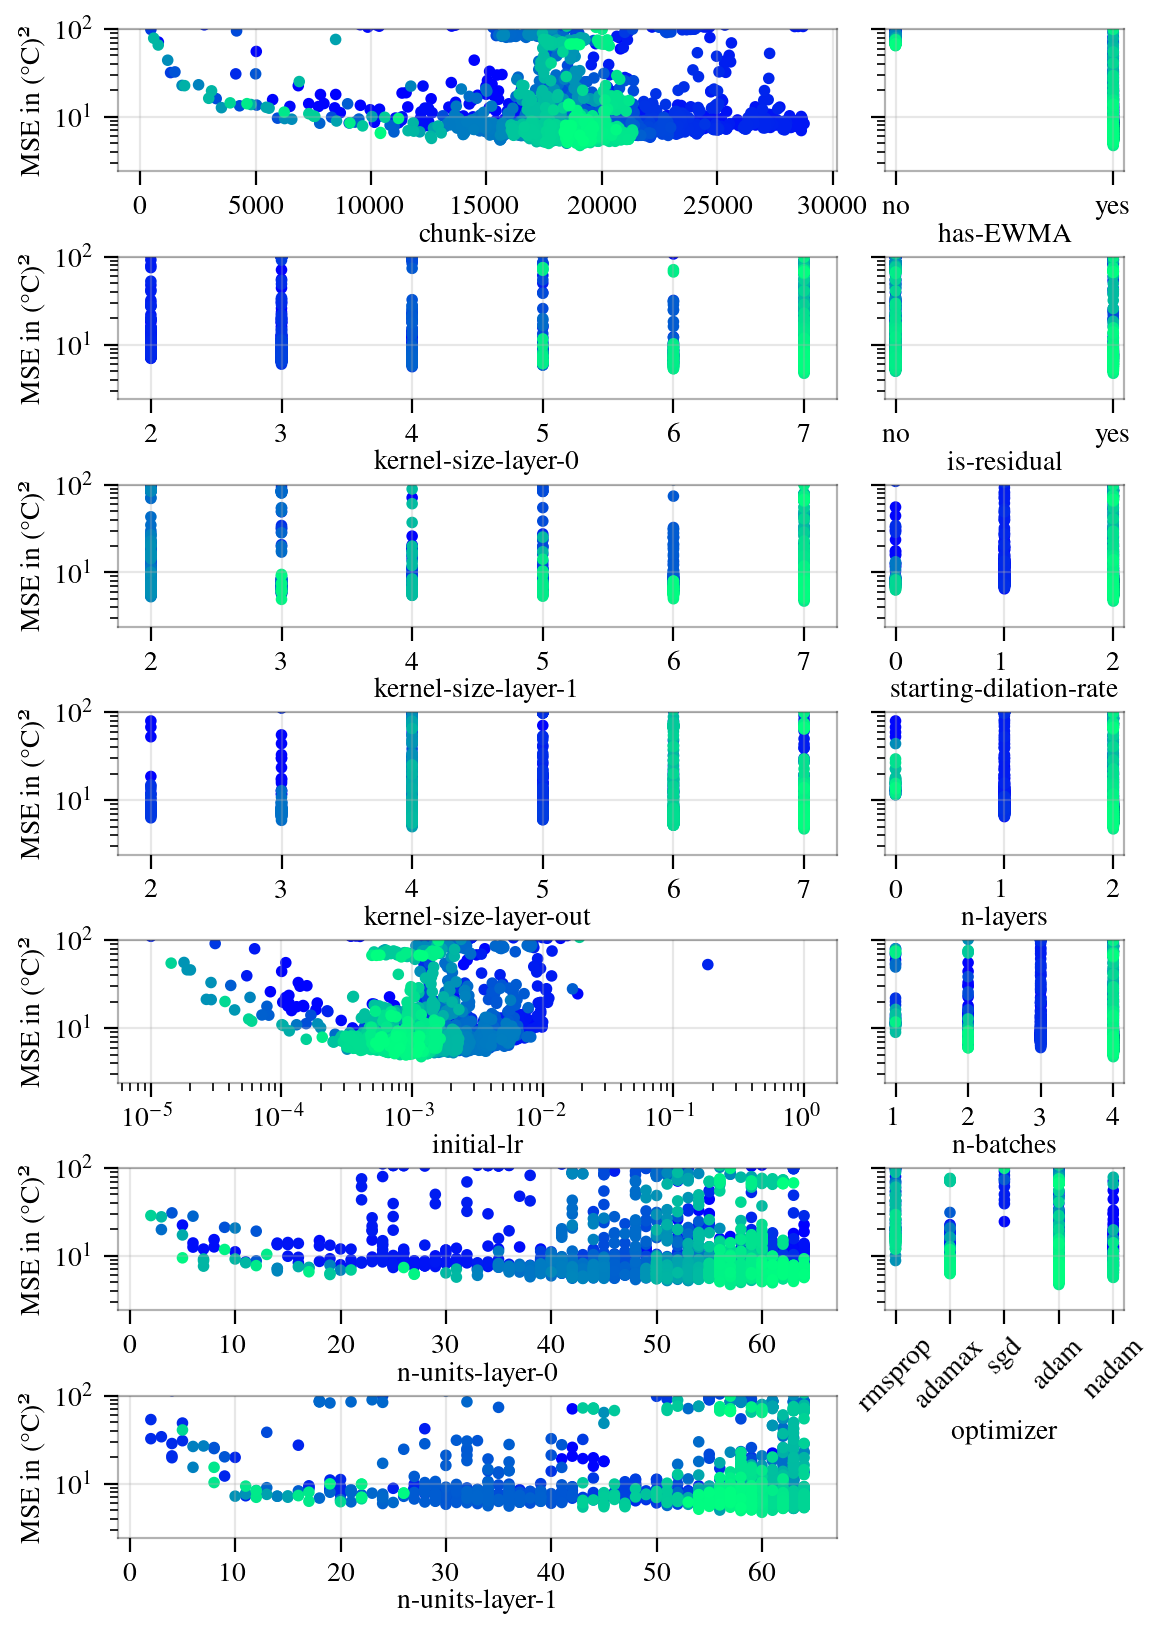

In [14]:
# HP sensitivity
adapt_params = [c for c in study_df_tcn if c not in (
    "number", "value", "datetime_start", "datetime_complete", "state", "duration")]
params = ['params_chunk_size', 'params_has_ewma',
          'params_kernel_size_layer_0', 'params_is_residual',
          'params_kernel_size_layer_1', 'params_starting_dilation_rate',
          'params_kernel_size_layer_out', 'params_n_layers',
          'params_inital_lr', 'params_n_batches',
          'params_n_units_layer_0', 'params_optimizer',
          'params_n_units_layer_1', ]
assert set(params) == set(adapt_params), f'{set(params) - (set(adapt_params))}'
ncols = 2
nrows = np.ceil(len(params) / ncols).astype(int)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=200, width_ratios=(0.75, 0.25),
                         figsize=(6.49*fig_scale, 1.4*nrows*fig_scale), sharey=True, sharex=False)
#successful_trials_df = successful_trials_df.query("value < 150")
for ax, param in zip(axes.flatten(), params):
    visible_dots = successful_trials_df_tcn.loc[:, [param, "value", "number"]].dropna()
    if visible_dots.loc[:, param].dtype == object and not param.endswith("residual"):
        # for latex
        visible_dots.loc[:, param] = visible_dots.loc[:, param].str.replace('_', '-')
    ax.scatter(visible_dots.loc[:, param], visible_dots.loc[:, "value"],
               c=visible_dots.number, cmap='winter', label=None, s=10)
    ax.set_yscale("log")
    ax.set_ylim(None, 1e2)
    ax.set_xlabel(param.replace('params_', '').replace("_", "-").replace('inital', 'initial')
                  .replace('ewma', 'EWMA'), labelpad=1.0)
    if 'inital' in param:
        ax.set_xscale('log')
    elif 'optimizer' in param:
        ax.tick_params(axis='x', rotation=45)
    elif 'ewma' in param or 'residual' in param:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['no', 'yes'])
    elif 'batches' in param:
        ax.set_xticks(range(1, 5))
    elif 'n_layers' in param or 'starting_d' in param:
        ax.set_xticks(range(3))
    elif 'kernel' in param:
        ax.set_xticks(range(2, 8))
    if ax in [axes[i, 0] for i in range(nrows)]:
        ax.set_ylabel('MSE in (°C)²')
    prettify(ax)
axes[-1, -1].axis('off')
#axes[-1, -2].axis('off')
fig.subplots_adjust(hspace=0.6, wspace=0.1)
# fig.tight_layout()
fig.savefig(IMG_PATH / "diss_hpo_dist_tcn.jpg", dpi=300, bbox_inches="tight")


## Generalization

In [20]:
# generalization
meta_info = DBManager.query(f"SELECT experiment_id, seed, mse, l_infty_under, l_infty_over, model_size, model_tag, comment, hostname, started_at, finished_at FROM trials as t "
                            f"LEFT JOIN experiments as e ON t.experiment_id = e.id "
                            f"where comment ilike '%{study_name_tcn}%' "
                            f"and model_tag = 'tcn'"
                            f"ORDER BY t.mse ASC;")
meta_info['train_time'] = meta_info.finished_at - meta_info.started_at
best_models_tcn = meta_info.iloc[:5, :]
best_models_tcn


Test ssh tunnel..ok


experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          41481     8  3.552490     -13.061042      8.573499       49716   
1          41072     8  3.596699      -9.945125     11.594696       54162   
2          41443     6  3.671565     -10.519696     10.421175       48950   
3          41758     6  3.691206     -10.320170     12.002226       59141   
4          41641     2  3.714415     -15.472311     16.845778       62772   

  model_tag                           comment  hostname          started_at  \
0       tcn  HPO study_2_4_diss trial-nr 3699  n2cn0460 2023-02-10 08:27:53   
1       tcn  HPO study_2_4_diss trial-nr 3301  n2cn0578 2023-02-09 23:23:54   
2       tcn  HPO study_2_4_diss trial-nr 3682  n2cn0446 2023-02-10 07:56:17   
3       tcn  HPO study_2_4_diss trial-nr 3965  n2cn0449 2023-02-10 16:17:06   
4       tcn  HPO study_2_4_diss trial-nr 3865  n2cn0440 2023-02-10 13:07:39   

          finished_at      train_time  
0 2023-02-10 09:36:26 0 days 01:08:33  
1 2023-02-10 00:17:34 0 days 00:53:40  
2 2023-02-10 08:38:48 0 days 00:42:31  
3 2023-02-10 17:56:26 0 days 01:39:20  
4 2023-02-10 14:28:07 0 days 01:20:28

In [21]:
top_five = {}
best_models_tcn.loc[:, ['mse_gen', 'l_infty_gen']] = 0
for i in range(5):
    print("model", i)
    exp_info = best_models_tcn.iloc[i, :]
    print(f"Determine generalization capability of {exp_info.experiment_id} seed {exp_info.seed} "
          f"[{exp_info.model_size} params] (test set was {exp_info.mse} K²):")
    preds_tcn, ds_tcn, metrics, _ = evaluate_generalization(int(exp_info.experiment_id), int(exp_info.seed), 0)
    best_models_tcn.at[i, 'mse_gen'] = metrics['mse']
    best_models_tcn.at[i, 'l_infty_gen'] = metrics['l_infty']
    top_five[(exp_info.experiment_id, exp_info.seed)] = (preds_tcn, ds_tcn, metrics['mse'], metrics['l_infty'])


model 0
Determine generalization capability of 41481 seed 8 [49716 params] (test set was 3.5524898 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 25.660010453745628,
 'l_infty_over': 19.38519679572752,
 'l_infty_under': -25.660010453745628,
 'mae': 1.9117368517095066,
 'mse': 6.191213827083745,
 'r2': 0.9825057462554021}
model 1
Determine generalization capability of 41072 seed 8 [54162 params] (test set was 3.5966988 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 25.461951862446355,
 'l_infty_over': 20.89501983538761,
 'l_infty_under': -25.461951862446355,
 'mae': 2.4653759613879513,
 'mse': 10.005155207924322,
 'r2': 0.9741237321406869}
model 2
Determine generalization capability of 41443 seed 6 [48950 params] (test set was 3.6715646 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 24.26695920097022,
 'l_infty_over': 16.974086231147194,
 'l_infty_under': -24.266959200

Lowest worst case for 41443 seed 6 at MSE = 7.14 K² and e_max = 24.27 K


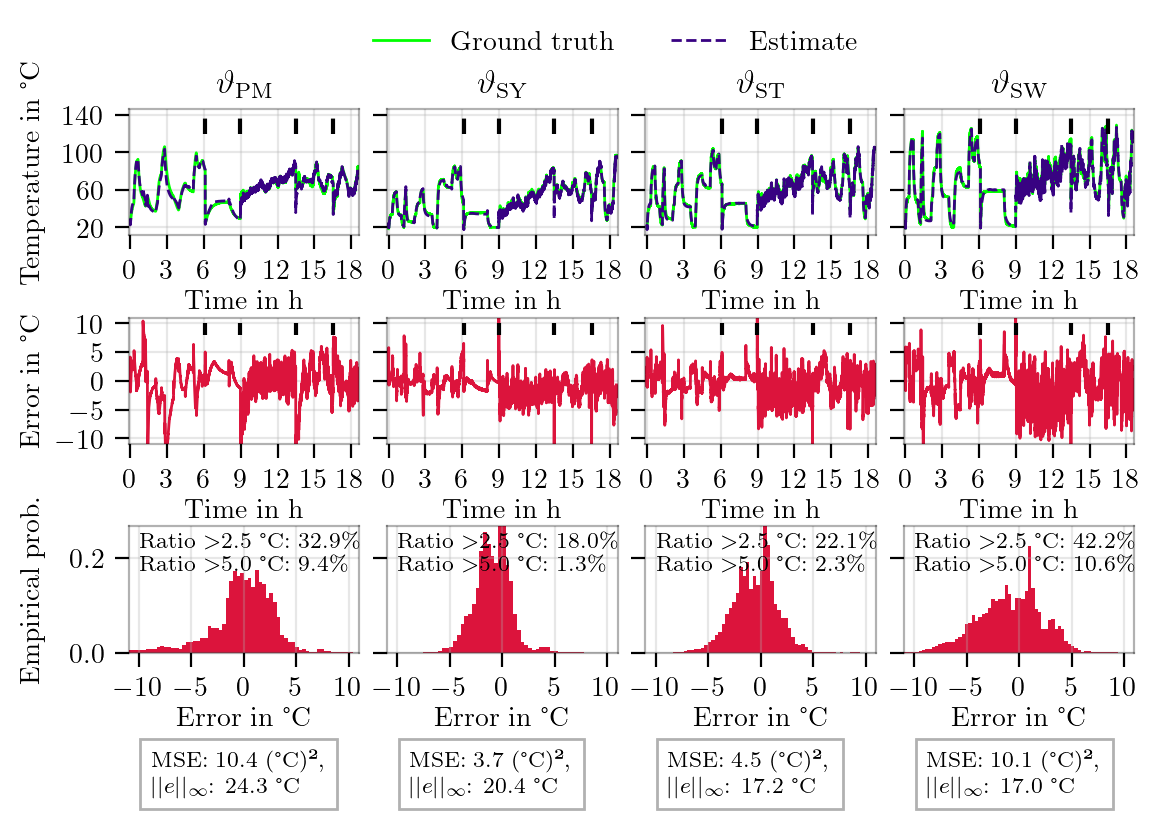

In [22]:
(expid, seed), (preds_tcn, ds_tcn, mse, worst_case) = min(top_five.items(), key=lambda v: v[1][-1])
print(f"Lowest worst case for {expid} seed {seed} at MSE = {mse:.2f} K² and e_max = {worst_case:.2f} K")
fig = show_error_trajectories_4_diss(preds_tcn, dataset=ds_tcn)

fig.savefig(IMG_PATH / "diss_hpo_perf_tcn.jpg", dpi=300, bbox_inches="tight")


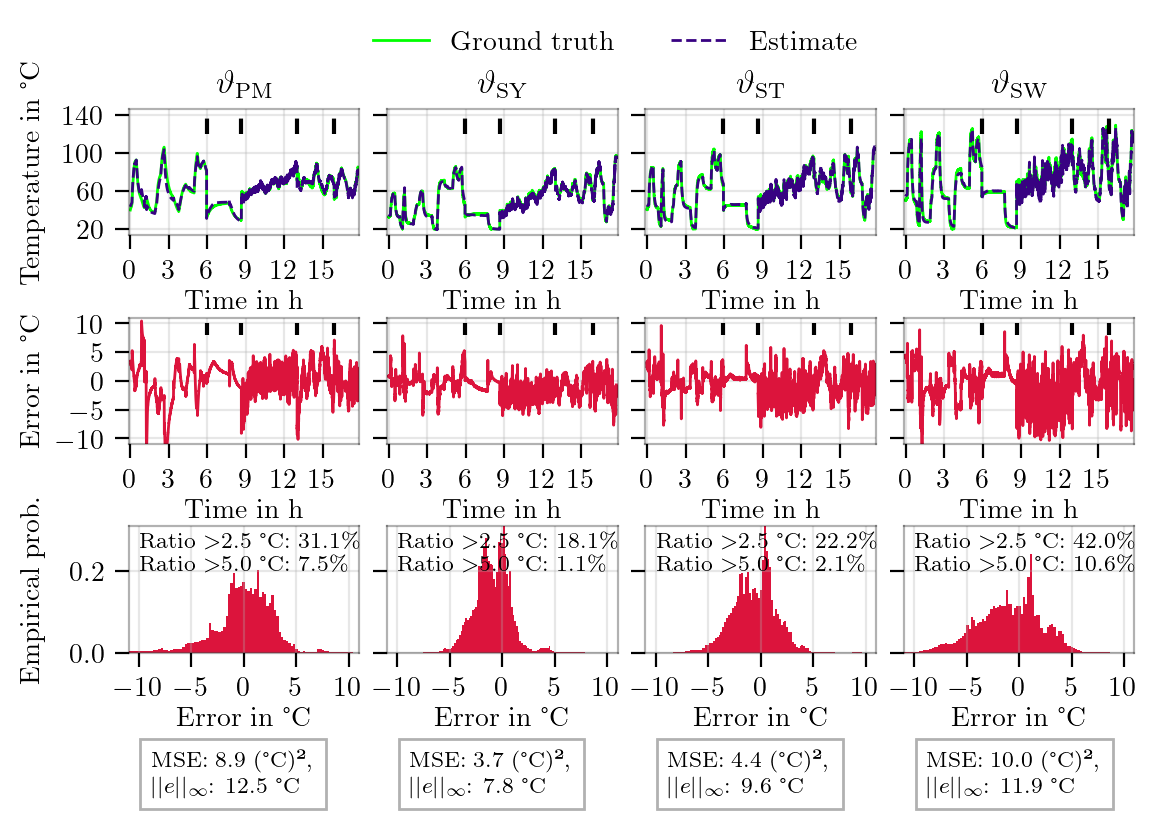

In [23]:
# crop first minutes
new_start = 60*2*10
cropped_preds = pd.concat([df.iloc[new_start:, :]
                          for _, df in preds_tcn.groupby(ds_tcn.pid, sort=False)], ignore_index=True)
cropped_ds = deepcopy(ds_tcn)
cropped_ds.data = pd.concat([df.iloc[new_start:, :] for _, df in cropped_ds.data.groupby(cropped_ds.pid, sort=False)],
                            ignore_index=True)

fig = show_error_trajectories_4_diss(cropped_preds, dataset=cropped_ds)


# GRU HPO

In [15]:
STUDY_NAME = 'study_4_diss_gru'
PSQLDB_NAME = 'optuna'
with open(f'{os.getenv("HOME")}/creds/optuna_psql', 'r') as f:
    optuna_creds = ':'.join([s.strip() for s in f.readlines()])
server_name = 'lea38'
tun_cfg = dict(remote_bind_address=('localhost', 5432))
tunnel = sshtunnel.SSHTunnelForwarder(server_name, **tun_cfg)
with tunnel:
    storage_str = f'postgresql://{optuna_creds}@localhost:{tunnel.local_bind_port}/{PSQLDB_NAME}'

    loaded_study = optuna.create_study(storage=storage_str, study_name=STUDY_NAME,
                                       load_if_exists=True, direction="minimize")
    study_df_gru = loaded_study.trials_dataframe()


[I 2023-08-25 11:49:13,780] Using an existing study with name 'study_4_diss_gru' instead of creating a new one.


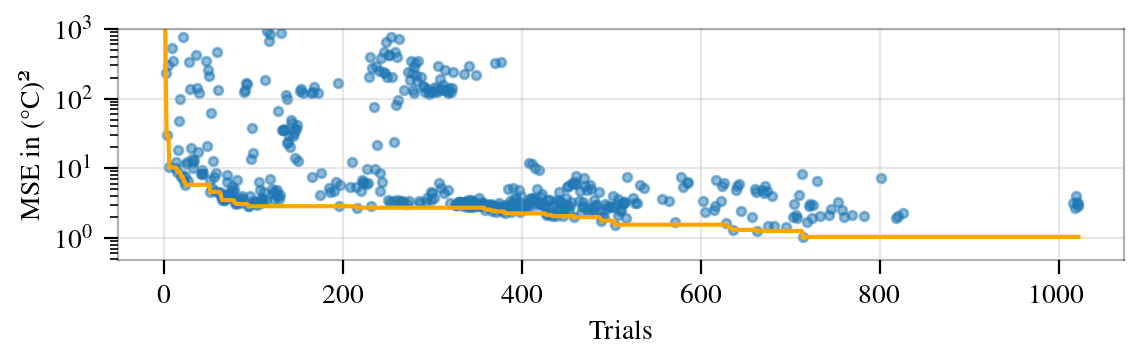

In [16]:
# opt trend
fig = plt.figure(figsize=(6.49*fig_scale, 1.5*fig_scale), dpi=200)
successful_trials_df_gru = study_df_gru.query("state == 'COMPLETE'")
plt.scatter(successful_trials_df_gru.number, successful_trials_df_gru.value, alpha=0.5, s=10)
plt.plot(successful_trials_df_gru.number, np.minimum.accumulate(successful_trials_df_gru.value), color='orange')

plt.xlabel("Trials")
plt.ylabel("MSE in (°C)²")
plt.yscale("log")
plt.ylim(None, 1e3)
# plt.xscale('log')
#plt.legend(frameon=True, markerscale=3)
prettify(plt.gca())
#plt.title("Objective trend GRU")
fig.savefig(IMG_PATH / "diss_hpo_trend_gru.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [26]:
successful_trials_df_gru.sort_values("value")


number         value             datetime_start  \
714     714  1.033515e+00 2023-02-11 15:58:42.463519   
663     663  1.258985e+00 2023-02-11 14:59:25.981813   
636     636  1.303393e+00 2023-02-11 13:59:03.675403   
695     695  1.429540e+00 2023-02-11 15:27:45.055687   
675     675  1.461265e+00 2023-02-11 15:06:14.434957   
..      ...           ...                        ...   
11       11  3.988532e+06 2023-02-07 09:37:53.171286   
0         0  3.988532e+06 2023-02-06 15:26:41.846118   
12       12  3.995399e+06 2023-02-07 10:38:28.427237   
7         7  4.022151e+06 2023-02-07 00:05:18.643738   
35       35  4.145396e+06 2023-02-08 01:58:26.156810   

             datetime_complete               duration  params_chunk_size  \
714 2023-02-11 19:24:42.434714 0 days 03:25:59.971195              23983   
663 2023-02-11 18:25:11.680804 0 days 03:25:45.698991              23889   
636 2023-02-11 17:38:25.844254 0 days 03:39:22.168851              24418   
695 2023-02-11 18:55:06.663278 0 days 03:27:21.607591              24249   
675 2023-02-11 18:41:31.905211 0 days 03:35:17.470254              24266   
..                         ...                    ...                ...   
11  2023-02-07 12:11:55.934355 0 days 02:34:02.763069              14022   
0   2023-02-06 17:13:10.284318 0 days 01:46:28.438200              10179   
12  2023-02-07 14:30:24.421957 0 days 03:51:55.994720              13891   
7   2023-02-07 03:11:05.651598 0 days 03:05:47.007860               7632   
35  2023-02-08 02:55:26.865173 0 days 00:57:00.708363              12862   

    params_has_ewma  params_inital_lr params_is_residual  params_n_batches  \
714           False          0.003800              False                 4   
663           False          0.001820              False                 4   
636           False          0.001884              False                 4   
695           False          0.003751              False                 4   
675           False          0.001759              False                 4   
..              ...               ...                ...               ...   
11             True          0.870709               True                 3   
0              True          0.000158               True                 3   
12             True          0.536749               True                 3   
7              True          0.101068               True                 2   
35            False          0.493729               True                 1   

     params_n_layers  params_n_units_layer_0  params_n_units_layer_1  \
714              2.0                    60.0                    15.0   
663              2.0                    57.0                    31.0   
636              2.0                    64.0                    17.0   
695              2.0                    60.0                    17.0   
675              2.0                    57.0                    35.0   
..               ...                     ...                     ...   
11               1.0                    33.0                     NaN   
0                2.0                    13.0                    47.0   
12               1.0                    34.0                     NaN   
7                2.0                    43.0                    64.0   
35               1.0                    13.0                     NaN   

    params_optimizer  params_tbptt_len     state  
714            nadam            2205.0  COMPLETE  
663            nadam            2209.0  COMPLETE  
636            nadam            2054.0  COMPLETE  
695            nadam            2226.0  COMPLETE  
675            nadam            2219.0  COMPLETE  
..               ...               ...       ...  
11              adam            3926.0  COMPLETE  
0                sgd            7858.0  COMPLETE  
12              adam            4085.0  COMPLETE  
7            rmsprop            1359.0  COMPLETE  
35               sgd            8429.0  COMPLETE  

[519

In [27]:
successful_trials_df_gru.loc[successful_trials_df_gru.number == 724, :]

number     value             datetime_start          datetime_complete  \
724     724  1.913564 2023-02-11 16:17:46.043922 2023-02-11 19:58:56.777751   

                  duration  params_chunk_size params_has_ewma  \
724 0 days 03:41:10.733829              22834           False   

     params_inital_lr params_is_residual  params_n_batches  params_n_layers  \
724          0.003958              False                 4              2.0   

     params_n_units_layer_0  params_n_units_layer_1 params_optimizer  \
724                    57.0                    40.0            nadam   

     params_tbptt_len     state  
724            2316.0  COMPLETE

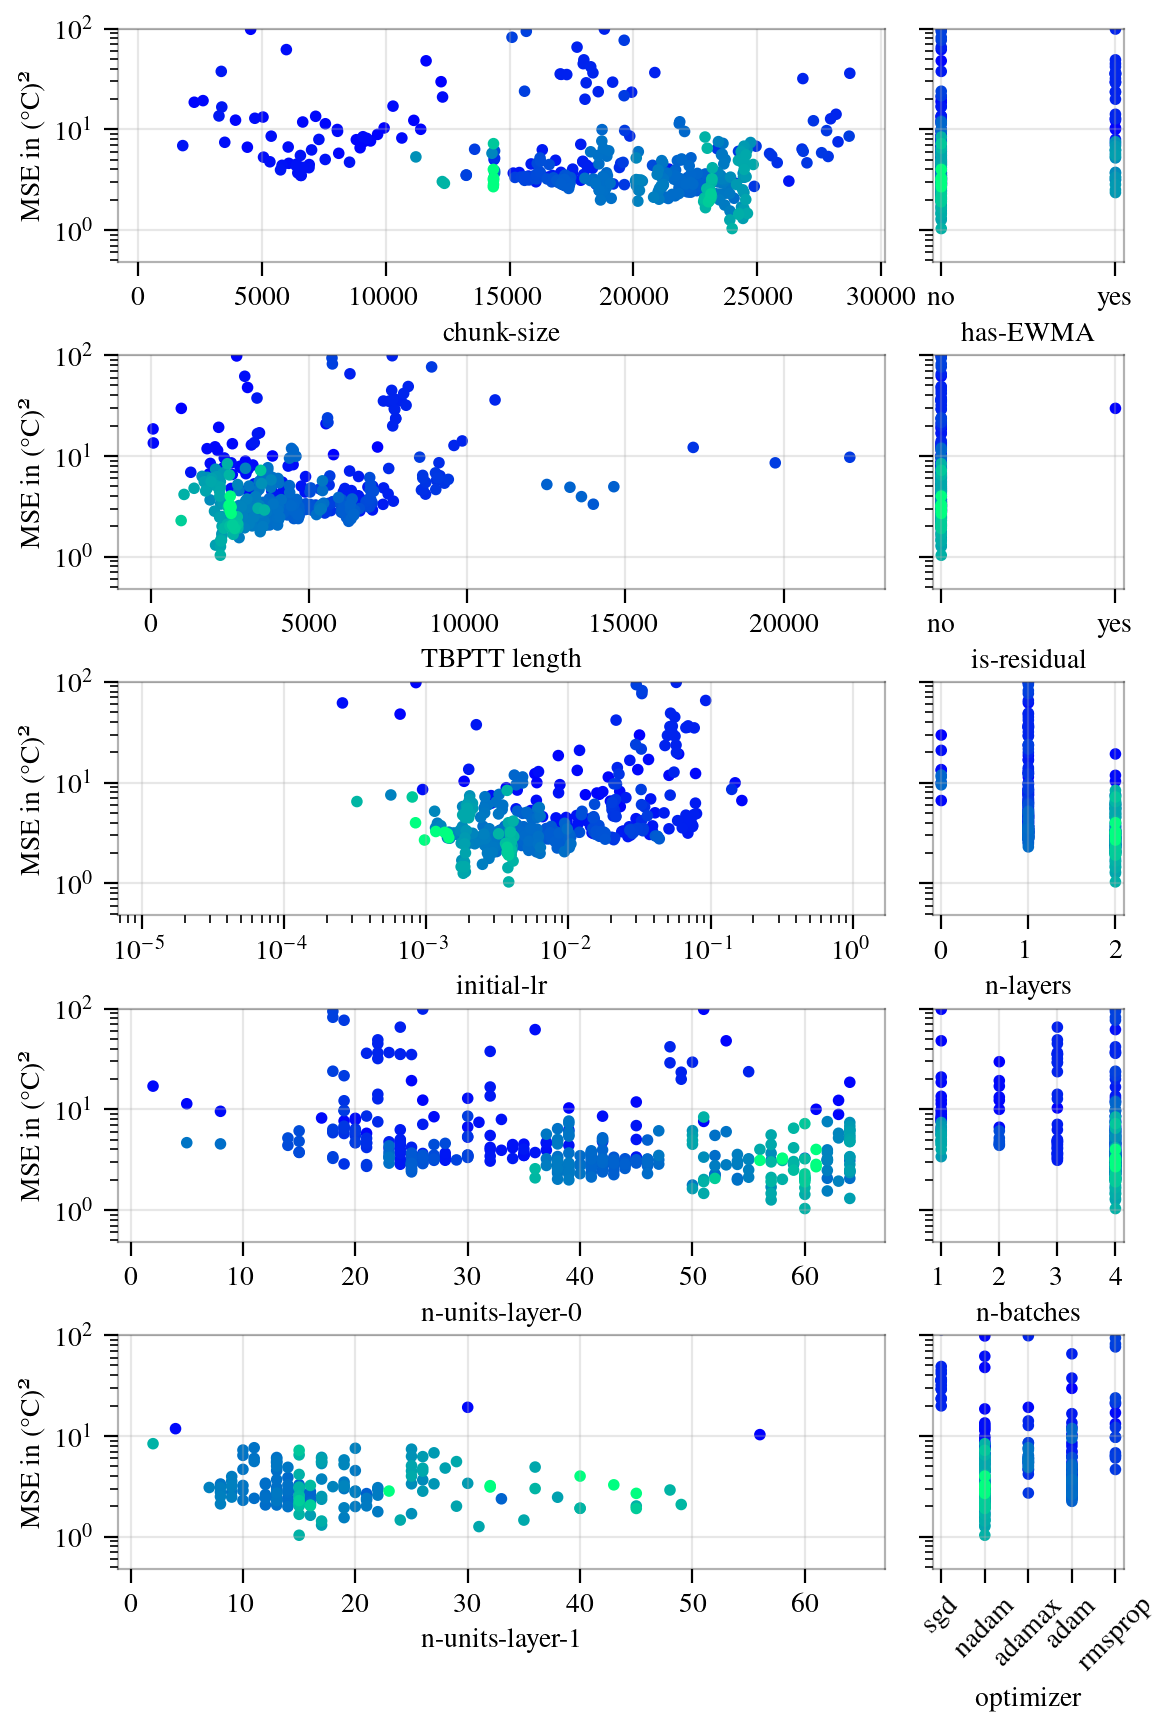

In [19]:
# HP sensitivity
adapt_params = [c for c in study_df_gru if c not in (
    "number", "value", "datetime_start", "datetime_complete", "state", "duration")]
params = ['params_chunk_size', 'params_has_ewma',
          'params_tbptt_len', 'params_is_residual',
          'params_inital_lr', 'params_n_layers',
          'params_n_units_layer_0', 'params_n_batches',
          'params_n_units_layer_1', 'params_optimizer']
assert set(params) == set(adapt_params)
ncols = 2
nrows = np.ceil(len(params) / ncols).astype(int)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, width_ratios=(0.8, 0.2), dpi=200,
                         figsize=(6.49*fig_scale, nrows*2*fig_scale), sharey=True, sharex=False)
#successful_trials_df = successful_trials_df.query("value < 150")
for ax, param in zip(axes.flatten(), params):
    visible_dots = successful_trials_df_gru.loc[:, [param, "value", "number"]].dropna()
    if visible_dots.loc[:, param].dtype == object and not param.endswith(("residual", "has_ewma")):
        # for latex
        visible_dots.loc[:, param] = visible_dots.loc[:, param].str.replace('_', '-')
    ax.scatter(visible_dots.loc[:, param], visible_dots.loc[:, "value"],
               c=visible_dots.number, cmap='winter', label=None, s=10)
    ax.set_yscale("log")
    ax.set_ylim(None, 1e2)
    ax.set_xlabel(param.replace('params_', '').replace("_", "-").replace('inital', 'initial')
                  .replace('tbptt-len', 'TBPTT length').replace('ewma', 'EWMA'))
    if 'inital' in param:
        ax.set_xscale('log')
    elif 'optimizer' in param:
        ax.tick_params(axis='x', rotation=45)
    elif 'ewma' in param or 'residual' in param:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['no', 'yes'])
    elif 'batches' in param:
        ax.set_xticks(range(1, 5))
    elif 'n_layers' in param:
        ax.set_xticks(range(3))
    if ax in [axes[i, 0] for i in range(nrows)]:
        ax.set_ylabel('MSE in (°C)²')
    prettify(ax)
fig.subplots_adjust(hspace=0.4, wspace=0.1)

fig.savefig(IMG_PATH / "diss_hpo_dist_gru.jpg", dpi=300, bbox_inches="tight")


## Generalization

In [29]:
# generalization
meta_info = DBManager.query(f"SELECT experiment_id, seed, mse, l_infty_under, l_infty_over, model_size, model_tag, comment, hostname, started_at, finished_at FROM trials as t "
                            f"LEFT JOIN experiments as e ON t.experiment_id = e.id "
                            f"where comment ilike '%study_4_diss%' "
                            f"and model_tag = 'gru'"
                            f"ORDER BY t.mse ASC;")
meta_info['train_time'] = meta_info.finished_at - meta_info.started_at
best_models_gru = meta_info.iloc[:5, :]

best_models_gru


Test ssh tunnel..ok


experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          42442     7  1.033515      -3.950885      5.293240       17217   
1          42186     8  1.148203      -5.140224      5.138707       18477   
2          42475     4  1.185604      -4.543794      6.176802       24744   
3          42115     0  1.201846      -4.117386      5.153569        4788   
4          42397     7  1.258985      -6.230548      4.143750       21126   

  model_tag                        comment  hostname          started_at  \
0       gru  HPO study_4_diss trial-nr 714  n2cn0296 2023-02-11 15:59:50   
1       gru  HPO study_4_diss trial-nr 446  n2cn0528 2023-02-11 06:10:59   
2       gru  HPO study_4_diss trial-nr 724  n2cn0511 2023-02-11 16:19:00   
3       gru  HPO study_4_diss trial-nr 367  n2cn0435 2023-02-11 02:47:05   
4       gru  HPO study_4_diss trial-nr 663  n2cn0795 2023-02-11 15:00:44   

          finished_at      train_time  
0 2023-02-11 19:24:37 0 days 03:24:47  
1 2023-02-11 09:17:16 0 days 03:06:17  
2 2023-02-11 19:58:09 0 days 03:39:09  
3 2023-02-11 05:47:56 0 days 03:00:51  
4 2023-02-11 18:25:06 0 days 03:24:22

In [30]:
top_five = {}
best_models_gru.loc[:, ['mse_gen', 'l_infty_gen']] = 0
for i in range(5):
    print("model", i)
    exp_info = best_models_gru.iloc[i, :]
    print(f"Determine generalization capability of {exp_info.experiment_id} seed {exp_info.seed} "
          f"[{exp_info.model_size} params] (test set was {exp_info.mse} K²):")
    preds_gru, ds_gru, metrics, _ = evaluate_generalization(int(exp_info.experiment_id), int(exp_info.seed), 0)
    best_models_gru.at[i, 'mse_gen'] = metrics['mse']
    best_models_gru.at[i, 'l_infty_gen'] = metrics['l_infty']
    top_five[(exp_info.experiment_id, exp_info.seed)] = (preds_gru, ds_gru, metrics['mse'], metrics['l_infty'])


model 0
Determine generalization capability of 42442 seed 7 [17217 params] (test set was 1.0335153 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 6.641706108583364,
 'l_infty_over': 6.026714373866469,
 'l_infty_under': -6.641706108583364,
 'mae': 0.7729475571839908,
 'mse': 1.1060078811066545,
 'r2': 0.99669589183934}
model 1
Determine generalization capability of 42186 seed 8 [18477 params] (test set was 1.148203 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 10.008617519868764,
 'l_infty_over': 5.145386695861816,
 'l_infty_under': -10.008617519868764,
 'mae': 0.9685907215874991,
 'mse': 1.613139426502533,
 'r2': 0.9953668186112092}
model 2
Determine generalization capability of 42475 seed 4 [24744 params] (test set was 1.1856037 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 5.457063793672475,
 'l_infty_over': 4.526179313659682,
 'l_infty_under': -5.457063793672475,

In [31]:
best_models_gru


experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          42442     7  1.033515      -3.950885      5.293240       17217   
1          42186     8  1.148203      -5.140224      5.138707       18477   
2          42475     4  1.185604      -4.543794      6.176802       24744   
3          42115     0  1.201846      -4.117386      5.153569        4788   
4          42397     7  1.258985      -6.230548      4.143750       21126   

  model_tag                        comment  hostname          started_at  \
0       gru  HPO study_4_diss trial-nr 714  n2cn0296 2023-02-11 15:59:50   
1       gru  HPO study_4_diss trial-nr 446  n2cn0528 2023-02-11 06:10:59   
2       gru  HPO study_4_diss trial-nr 724  n2cn0511 2023-02-11 16:19:00   
3       gru  HPO study_4_diss trial-nr 367  n2cn0435 2023-02-11 02:47:05   
4       gru  HPO study_4_diss trial-nr 663  n2cn0795 2023-02-11 15:00:44   

          finished_at      train_time   mse_gen  l_infty_gen  
0 2023-02-11 19:24:37 0 days 03:24:47  1.106008     6.641706  
1 2023-02-11 09:17:16 0 days 03:06:17  1.613139    10.008618  
2 2023-02-11 19:58:09 0 days 03:39:09  1.147823     5.457064  
3 2023-02-11 05:47:56 0 days 03:00:51  2.452636     7.514666  
4 2023-02-11 18:25:06 0 days 03:24:22  2.057343     6.816540

Lowest worst case for 42475 seed 4 at MSE = 1.15 K² and e_max = 5.46 K


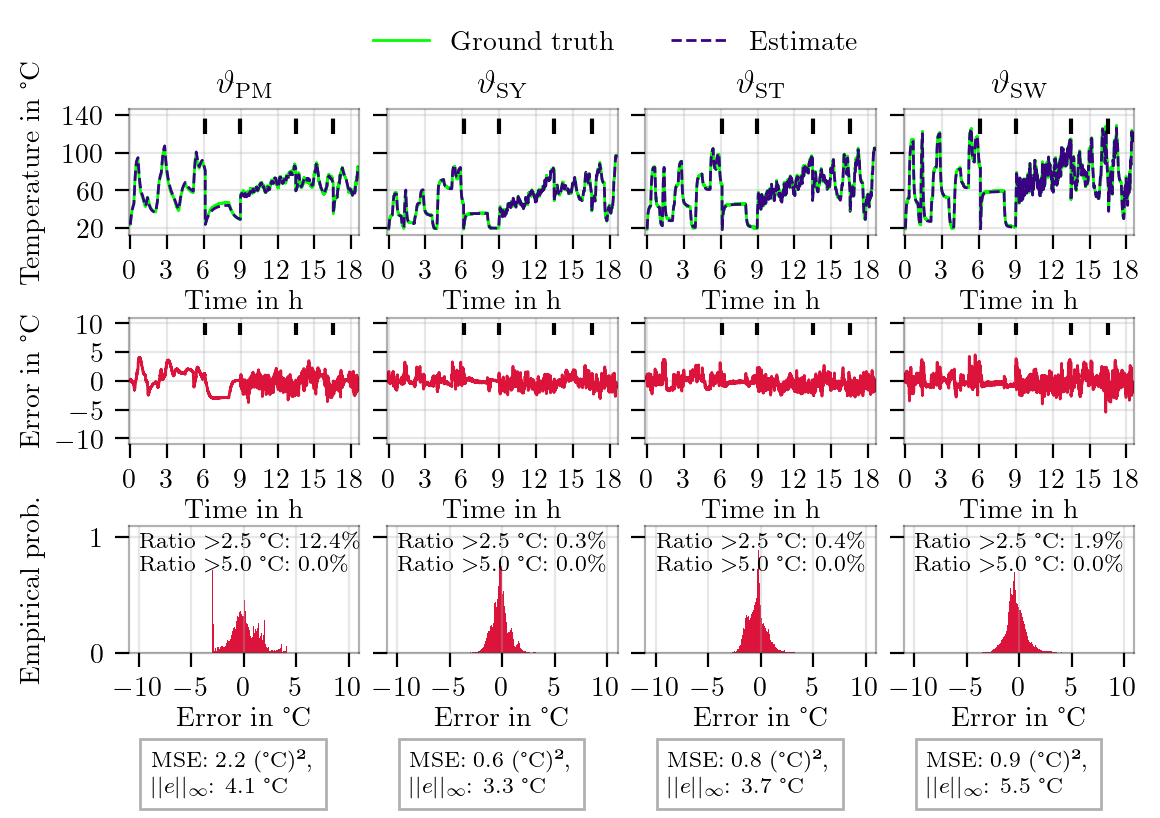

In [32]:
(expid, seed), (preds_gru, ds_gru, mse, worst_case) = min(top_five.items(), key=lambda v: v[1][-1])
print(f"Lowest worst case for {expid} seed {seed} at MSE = {mse:.2f} K² and e_max = {worst_case:.2f} K")
fig = show_error_trajectories_4_diss(preds_gru, dataset=ds_gru)

fig.savefig(IMG_PATH / "diss_hpo_perf_gru.jpg", dpi=300, bbox_inches="tight")


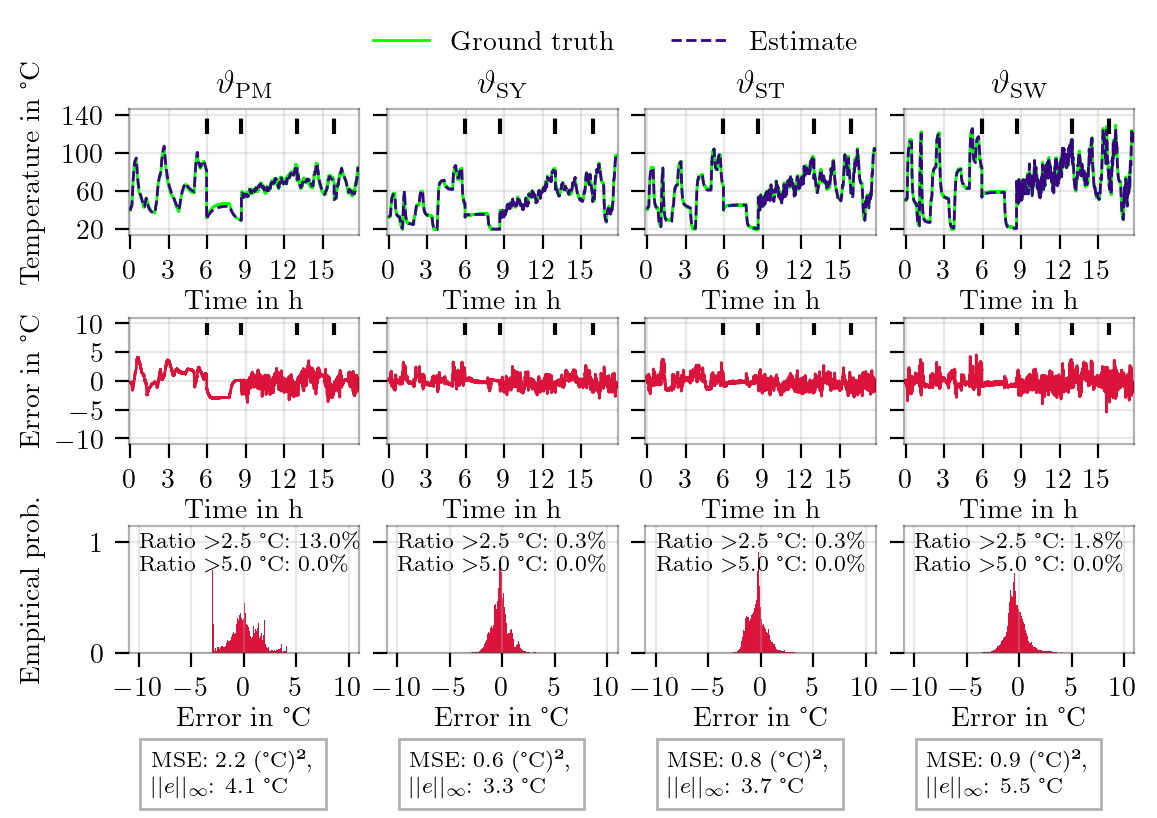

In [33]:
# crop first minutes
new_start = 60*2*10
cropped_preds = pd.concat([df.iloc[new_start:, :]
                          for _, df in preds_gru.groupby(ds_gru.pid, sort=False)], ignore_index=True)
cropped_ds = deepcopy(ds_gru)
cropped_ds.data = pd.concat([df.iloc[new_start:, :] for _, df in cropped_ds.data.groupby(cropped_ds.pid, sort=False)],
                            ignore_index=True)

fig = show_error_trajectories_4_diss(cropped_preds, dataset=cropped_ds)


# Comparison table GRU/TCN/TNN

In [20]:
best_models_gru


NameError: name 'best_models_gru' is not defined

In [35]:
best_models_tcn


experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          41481     8  3.552490     -13.061042      8.573499       49716   
1          41072     8  3.596699      -9.945125     11.594696       54162   
2          41443     6  3.671565     -10.519696     10.421175       48950   
3          41758     6  3.691206     -10.320170     12.002226       59141   
4          41641     2  3.714415     -15.472311     16.845778       62772   

  model_tag                           comment  hostname          started_at  \
0       tcn  HPO study_2_4_diss trial-nr 3699  n2cn0460 2023-02-10 08:27:53   
1       tcn  HPO study_2_4_diss trial-nr 3301  n2cn0578 2023-02-09 23:23:54   
2       tcn  HPO study_2_4_diss trial-nr 3682  n2cn0446 2023-02-10 07:56:17   
3       tcn  HPO study_2_4_diss trial-nr 3965  n2cn0449 2023-02-10 16:17:06   
4       tcn  HPO study_2_4_diss trial-nr 3865  n2cn0440 2023-02-10 13:07:39   

          finished_at      train_time    mse_gen  l_infty_gen  
0 2023-02-10 09:36:26 0 days 01:08:33   6.191214    25.660010  
1 2023-02-10 00:17:34 0 days 00:53:40  10.005155    25.461952  
2 2023-02-10 08:38:48 0 days 00:42:31   7.143415    24.266959  
3 2023-02-10 17:56:26 0 days 01:39:20  10.170157    29.361338  
4 2023-02-10 14:28:07 0 days 01:20:28   8.287789    46.909512

In [36]:
best_models_tnn


experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          84131     1  0.773041      -4.118918      4.766145        2033   
1          28214     0  0.846851      -3.828823      4.980471        1812   
2          67440     4  0.858587      -4.789726      4.834011        1967   
3          82577     8  0.859238      -4.319512      4.635611        1808   
4          31173     0  0.859973      -3.405189      5.099299        2148   

  model_tag   mse_gen  l_infty_gen  
0       tnn  1.591115     8.335099  
1       tnn  1.282123     6.778268  
2       tnn  1.611718     8.692916  
3       tnn  1.343349     6.712625  
4       tnn  1.477659     7.380173

In [37]:
black_box_models_df = pd.concat([best_models_gru.reset_index(), best_models_tcn.reset_index()], ignore_index=True)\
    .rename(columns={'index': 'Rank', 'model_tag': 'Model'})\
    .assign(l_infty=lambda x: x.loc[:, ['l_infty_under', 'l_infty_over']].abs().max(axis=1),
            Model=lambda s: s.Model.str.upper(), rank=lambda r: r.loc[:, 'Rank'] + 1)\
    .drop(columns=['l_infty_under', 'l_infty_over', 'experiment_id', 'seed',])
black_box_models_df_formatted = black_box_models_df.groupby(['Rank', 'Model'])\
    .agg('min').loc[:, ['mse', 'mse_gen', 'l_infty', 'l_infty_gen', 'model_size']].unstack().round(2)
black_box_models_df_formatted

mse       mse_gen        l_infty        l_infty_gen        model_size  \
Model   GRU   TCN     GRU    TCN     GRU    TCN         GRU    TCN        GRU   
Rank                                                                            
0      1.03  3.55    1.11   6.19    5.29  13.06        6.64  25.66      17217   
1      1.15  3.60    1.61  10.01    5.14  11.59       10.01  25.46      18477   
2      1.19  3.67    1.15   7.14    6.18  10.52        5.46  24.27      24744   
3      1.20  3.69    2.45  10.17    5.15  12.00        7.51  29.36       4788   
4      1.26  3.71    2.06   8.29    6.23  16.85        6.82  46.91      21126   

              
Model    TCN  
Rank          
0      49716  
1      54162  
2      48950  
3      59141  
4      62772

In [38]:
# print to latex
print(black_box_models_df_formatted.to_latex(
    label='tab:top_five_blackbox_hpo', 
    caption="Top five models according to the test set MSE"))


\begin{table}
\caption{Top five models according to the test set MSE}
\label{tab:top_five_blackbox_hpo}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{mse} & \multicolumn{2}{r}{mse_gen} & \multicolumn{2}{r}{l_infty} & \multicolumn{2}{r}{l_infty_gen} & \multicolumn{2}{r}{model_size} \\
Model & GRU & TCN & GRU & TCN & GRU & TCN & GRU & TCN & GRU & TCN \\
Rank &  &  &  &  &  &  &  &  &  &  \\
\midrule
0 & 1.030000 & 3.550000 & 1.110000 & 6.190000 & 5.290000 & 13.060000 & 6.640000 & 25.660000 & 17217 & 49716 \\
1 & 1.150000 & 3.600000 & 1.610000 & 10.010000 & 5.140000 & 11.590000 & 10.010000 & 25.460000 & 18477 & 54162 \\
2 & 1.190000 & 3.670000 & 1.150000 & 7.140000 & 6.180000 & 10.520000 & 5.460000 & 24.270000 & 24744 & 48950 \\
3 & 1.200000 & 3.690000 & 2.450000 & 10.170000 & 5.150000 & 12.000000 & 7.510000 & 29.360000 & 4788 & 59141 \\
4 & 1.260000 & 3.710000 & 2.060000 & 8.290000 & 6.230000 & 16.850000 & 6.820000 & 46.910000 & 21126 & 62772 \\
\bottomrule
\end{tabular}
\e

# Model size analysis  
Visualize MSE over model size for smallest sizes as found in HPO

In [3]:
study_name_tcn = "study_2_4_diss"
meta_info = DBManager.query(f"SELECT experiment_id, seed, mse, l_infty_under, l_infty_over, model_size, model_tag, comment, started_at, finished_at, hostname FROM trials as t "
                            f"LEFT JOIN experiments as e ON t.experiment_id = e.id "
                            f"where (comment ilike '%{study_name_tcn}%' and model_tag = 'tcn') or (comment ilike '%study_4_diss%' and model_tag = 'gru') "
                            f"ORDER BY t.mse ASC;")
meta_info['WorstCase'] = meta_info.loc[:, ["l_infty_over", "l_infty_under"]].abs().max(axis=1)
meta_info['train_time'] = meta_info.finished_at - meta_info.started_at
meta_info

Test ssh tunnel..ok


experiment_id  seed           mse  l_infty_under  l_infty_over  \
0              42442     7  1.033515e+00      -3.950885      5.293240   
1              42186     8  1.148203e+00      -5.140224      5.138707   
2              42475     4  1.185604e+00      -4.543794      6.176802   
3              42115     0  1.201846e+00      -4.117386      5.153569   
4              42397     7  1.258985e+00      -6.230548      4.143750   
...              ...   ...           ...            ...           ...   
48158          42038     5  4.120877e+06   -2129.214800   1974.272000   
48159          37434     5  4.130504e+06   -2129.214800   1974.329200   
48160          37528     4  4.133665e+06   -2129.214800   1975.241000   
48161          38608     5  4.145396e+06   -2129.214800   1975.916100   
48162          36143     7  4.148808e+06   -2129.214800   1976.097400   

       model_size model_tag                        comment  \
0           17217       gru  HPO study_4_diss trial-nr 714   
1           18477       gru  HPO study_4_diss trial-nr 446   
2           24744       gru  HPO study_4_diss trial-nr 724   
3            4788       gru  HPO study_4_diss trial-nr 367   
4           21126       gru  HPO study_4_diss trial-nr 663   
...           ...       ...                            ...   
48158        4288       gru  HPO study_4_diss trial-nr 289   
48159       12682       gru   HPO study_4_diss trial-nr 11   
48160       13166       gru   HPO study_4_diss trial-nr 12   
48161        1376       gru   HPO study_4_diss trial-nr 35   
48162       14206       gru    HPO study_4_diss trial-nr 0   

               started_at         finished_at       hostname    WorstCase  \
0     2023-02-11 15:59:50 2023-02-11 19:24:37       n2cn0296     5.293240   
1     2023-02-11 06:10:59 2023-02-11 09:17:16       n2cn0528     5.140224   
2     2023-02-11 16:19:00 2023-02-11 19:58:09       n2cn0511     6.176802   
3     2023-02-11 02:47:05 2023-02-11 05:47:56       n2cn0435     5.153569   
4     2023-02-11 15:00:44 2023-02-11 18:25:06       n2cn0795     6.230548   
...                   ...                 ...            ...          ...   
48158 2023-02-11 00:08:10 2023-02-11 02:04:25       n2cn0257  2129.214800   
48159 2023-02-07 09:38:00 2023-02-07 12:11:23        lea-ava  2129.214800   
48160 2023-02-07 10:38:40 2023-02-07 14:28:09  lea-cyberdyne  2129.214800   
48161 2023-02-08 01:58:30 2023-02-08 02:55:23  lea-cyberdyne  2129.214800   
48162 2023-02-06 15:26:51 2023-02-06 17:11:42        lea-ava  2129.214800   

           train_time  
0     0 days 03:24:47  
1     0 days 03:06:17  
2     0 days 03:39:09  
3     0 days 03:00:51  
4     0 days 03:24:22  
...               ...  
48158 0 days 01:56:15  
48159 0 days 02:33:23  
48160 0 days 03:49:29  
48161 0 days 00:56:53  
48162 0 days 01:44:51  

[48163 rows x 13 columns]

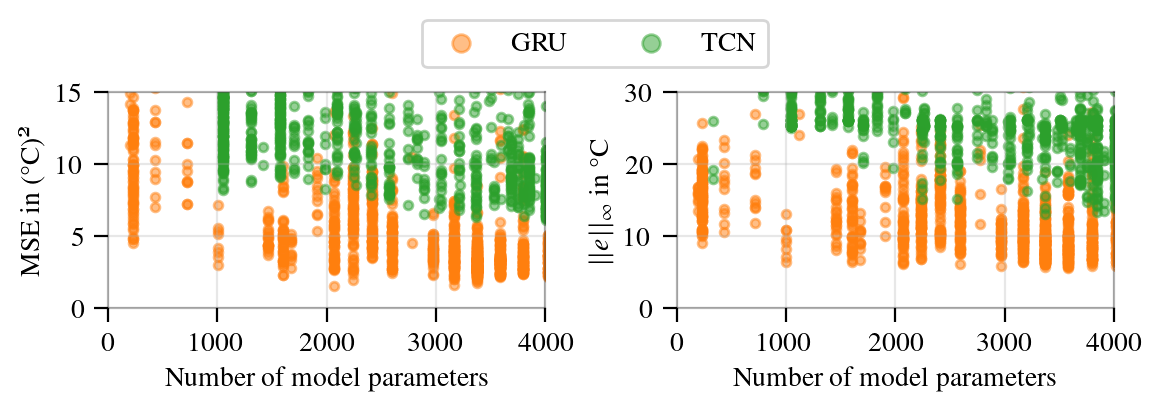

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(6.49, 1.4), sharex=True, dpi=200)
for (mdl, mdl_df), clr in zip(meta_info.groupby('model_tag'), ['#ff7f0e', 'tab:green']):
    axes[0].scatter( mdl_df.model_size, mdl_df.mse, label=mdl.upper(), s=10, alpha=0.5, color=clr)
    axes[1].scatter(mdl_df.model_size, mdl_df.WorstCase,  label=mdl.upper(), s=10, alpha=0.5, color=clr)
    
    axes[0].set_xlim(0, 4_000)
    axes[1].set_xlim(0, 4_000)

    axes[0].set_ylim(0, 15)
    axes[1].set_ylim(0, 30)
    #axes[1].legend(loc='upper right', framealpha=1.0, )
    axes[0].set_ylabel('MSE in (°C)²')
    axes[1].set_ylabel('$||e||_\infty$ in °C')
    axes[0].set_xlabel('Number of model parameters')
    axes[1].set_xlabel('Number of model parameters')
prettify(axes[0])
prettify(axes[1])
fig.subplots_adjust(hspace=0.9, wspace=0.3)
axes[0].legend(ncol=2, loc='lower center', bbox_to_anchor=(.5, 0.92),
                                  # axes[0, 1].transAxes
                                  bbox_transform=fig.transFigure,
                                  frameon=True, markerscale=2.0
                                  )
fig.savefig(IMG_PATH / "diss_modelsize_analysis_gru_tcn.jpg", dpi=300, bbox_inches="tight")

In [5]:
study_name_tnn = "study_4_diss_reduce_lr"
meta_info_tnn = DBManager.query(f"SELECT experiment_id, seed, mse, l_infty_under, l_infty_over, model_size, model_tag, comment, started_at, finished_at, hostname, layer_cfg FROM trials as t "
                            f"LEFT JOIN experiments as e ON t.experiment_id = e.id "
                            f"where (comment ilike '%{study_name_tnn}%' and model_tag = 'tnn') "
                            f"ORDER BY t.mse ASC;")
meta_info_tnn['WorstCase'] = meta_info_tnn.loc[:, ["l_infty_over", "l_infty_under"]].abs().max(axis=1)
meta_info_tnn['train_time'] = meta_info_tnn.finished_at - meta_info_tnn.started_at
meta_info_tnn['model_size'] += 4  # torchinfo < 1.7 unterschlägt capacitance constants
meta_info_tnn.sort_values(['model_size', 'WorstCase'])

Test ssh tunnel..ok


experiment_id  seed       mse  l_infty_under  l_infty_over  \
169955          85223     7  2.597593      -4.607194      5.608192   
209673          85223     6  3.143933      -6.397753      6.039819   
238035          85223     3  3.765874      -5.818227      6.525061   
233215          85223     9  3.635751      -4.691557      6.705030   
259955          85223     2  4.641000      -6.723171      7.182362   
...               ...   ...       ...            ...           ...   
211780          81279     9  3.180167      -5.090606      7.387416   
165799          81279     3  2.551244      -4.408055      7.485726   
272666          81279     8  5.646098      -3.994583      7.651057   
287050          81279     5  9.465339      -4.946015      9.469925   
218001          81279     4  3.296399      -3.411322     10.276232   

        model_size model_tag                                    comment  \
169955         117       tnn  HPO study_4_diss_reduce_lr trial-nr 34385   
209673         117       tnn  HPO study_4_diss_reduce_lr trial-nr 34385   
238035         117       tnn  HPO study_4_diss_reduce_lr trial-nr 34385   
233215         117       tnn  HPO study_4_diss_reduce_lr trial-nr 34385   
259955         117       tnn  HPO study_4_diss_reduce_lr trial-nr 34385   
...            ...       ...                                        ...   
211780       10049       tnn  HPO study_4_diss_reduce_lr trial-nr 30303   
165799       10049       tnn  HPO study_4_diss_reduce_lr trial-nr 30303   
272666       10049       tnn  HPO study_4_diss_reduce_lr trial-nr 30303   
287050       10049       tnn  HPO study_4_diss_reduce_lr trial-nr 30303   
218001       10049       tnn  HPO study_4_diss_reduce_lr trial-nr 30303   

                started_at         finished_at  hostname  \
169955 2023-03-01 10:40:02 2023-03-01 11:15:52  n2cn0512   
209673 2023-03-01 10:40:02 2023-03-01 11:15:22  n2cn0512   
238035 2023-03-01 10:40:02 2023-03-01 11:15:56  n2cn0512   
233215 2023-03-01 10:40:02 2023-03-01 11:16:06  n2cn0512   
259955 2023-03-01 10:40:02 2023-03-01 11:15:36  n2cn0512   
...                    ...                 ...       ...   
211780 2023-02-27 15:06:54 2023-02-27 15:58:40  n2cn0173   
165799 2023-02-27 15:06:54 2023-02-27 15:58:52  n2cn0173   
272666 2023-02-27 15:06:54 2023-02-27 15:58:40  n2cn0173   
287050 2023-02-27 15:06:54 2023-02-27 15:59:08  n2cn0173   
218001 2023-02-27 15:06:54 2023-02-27 15:58:51  n2cn0173   

                                                layer_cfg  WorstCase  \
169955  {"p": [{"units": 2, "activation": "tanh", "nam...   5.608192   
209673  {"p": [{"units": 2, "activation": "tanh", "nam...   6.397753   
238035  {"p": [{"units": 2, "activation": "tanh", "nam...   6.525061   
233215  {"p": [{"units": 2, "activation": "tanh", "nam...   6.705030   
259955  {"p": [{"units": 2, "activation": "tanh", "nam...   7.182362   
...                                                   ...        ...   
211780  {"p": [{"units": 49, "activation": "tanh", "na...   7.387416   
165799  {"p": [{"units": 49, "activation": "tanh", "na...   7.485726   
272666  {"p": [{"units": 49, "activation": "tanh", "na...   7.651057   
287050  {"p": [{"units": 49, "activation": "tanh", "na...   9.469925   
218001  {"p": [{"units": 49, "activation": "tanh", "na...  10.276232   

            train_time  
169955 0 days 00:35:50  
209673 0 days 00:35:20  
238035 0 days 00:35:54  
233215 0 days 00:36:04  
259955 0 days 00:35:34  
...                ...  
211780 0 days 00:51:46  
165799 0 days 00:51:58  
272666 0 days 00:51:46  
287050 0 days 00:52:14  
218001 0 days 00:51:57  

[334664 rows x 14 columns]

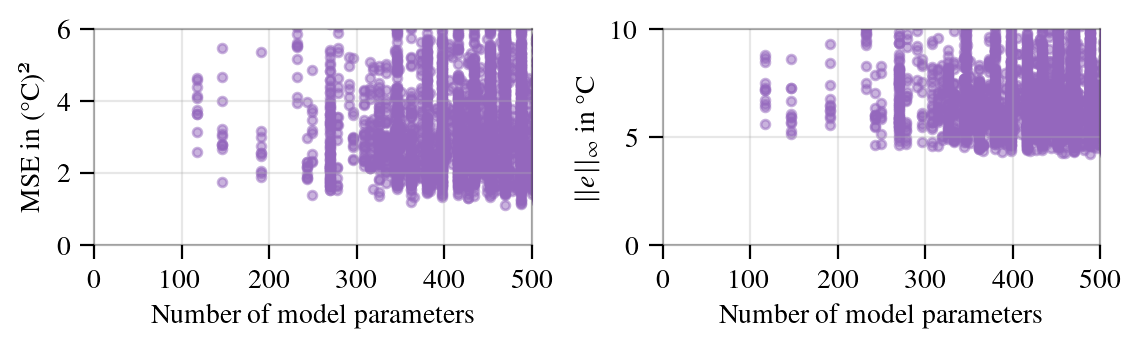

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6.49, 1.4), sharex=True, dpi=200)
#for (mdl, mdl_df), clr in zip(meta_info.groupby('model_tag'), ['#ff7f0e', 'tab:green']):
mdl = 'TNN'
mdl_df = meta_info_tnn
clr = 'tab:purple'
axes[0].scatter(mdl_df.model_size,mdl_df.mse,  label=mdl.upper(), s=10, alpha=0.5, color=clr)
axes[1].scatter(mdl_df.model_size,mdl_df.WorstCase,  label=mdl.upper(), s=10, alpha=0.5, color=clr)

axes[0].set_xlim(0, 500)
axes[1].set_xlim(0, 500)

axes[0].set_ylim(0, 6)
axes[1].set_ylim(0, 10)
#axes[1].legend(loc='upper right', framealpha=1.0, )
axes[0].set_ylabel('MSE in (°C)²')
axes[1].set_ylabel('$||e||_\infty$ in °C')
axes[0].set_xlabel('Number of model parameters')
axes[1].set_xlabel('Number of model parameters')
prettify(axes[0])
prettify(axes[1])
fig.subplots_adjust(hspace=0.9, wspace=0.3)
"""axes[0].legend(ncol=2, loc='lower center', bbox_to_anchor=(.5, 0.92),
                                  # axes[0, 1].transAxes
                                  bbox_transform=fig.transFigure,
                                  frameon=True, markerscale=2.0
                                  )"""
fig.savefig(IMG_PATH / "diss_modelsize_analysis_tnn.jpg", dpi=300, bbox_inches="tight")

## Generalization

In [43]:
best_grus = meta_info.query("model_tag == 'gru' and mse < 5.0").sort_values(['model_size', 'mse'], ascending=True)
best_grus.head(10)

experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
2544          38175    10  4.528795     -13.501563      8.421952         228   
3020          38183     0  4.760030     -12.624946      8.944840         228   
3155          38183     5  4.810463     -10.876777      9.509605         228   
3452          38175     1  4.909064      -8.515051      8.967686         228   
1052          42194     7  3.012897      -5.513825      7.059999        1002   
1581          42194     0  3.505426      -6.399873      6.261867        1002   
1879          42194     8  3.892432     -13.071528      5.499147        1002   
2079          42194    10  4.151607      -5.929854      9.566435        1002   
1760          42006     4  3.708670     -12.466803      7.392641        1458   
1886          42005     2  3.899744     -10.123231      8.191263        1458   

     model_tag                        comment          started_at  \
2544       gru   HPO study_4_diss trial-nr 27 2023-02-07 20:23:22   
3020       gru   HPO study_4_diss trial-nr 28 2023-02-07 20:40:18   
3155       gru   HPO study_4_diss trial-nr 28 2023-02-07 20:40:18   
3452       gru   HPO study_4_diss trial-nr 27 2023-02-07 20:23:22   
1052       gru  HPO study_4_diss trial-nr 465 2023-02-11 07:04:07   
1581       gru  HPO study_4_diss trial-nr 465 2023-02-11 07:04:07   
1879       gru  HPO study_4_diss trial-nr 465 2023-02-11 07:04:07   
2079       gru  HPO study_4_diss trial-nr 465 2023-02-11 07:04:07   
1760       gru  HPO study_4_diss trial-nr 300 2023-02-11 00:15:55   
1886       gru  HPO study_4_diss trial-nr 310 2023-02-11 00:30:38   

             finished_at       hostname  WorstCase      train_time  
2544 2023-02-07 20:38:41  lea-cyberdyne  13.501563 0 days 00:15:19  
3020 2023-02-07 20:54:29  lea-cyberdyne  12.624946 0 days 00:14:11  
3155 2023-02-07 20:54:14  lea-cyberdyne  10.876777 0 days 00:13:56  
3452 2023-02-07 20:38:57  lea-cyberdyne   8.967686 0 days 00:15:35  
1052 2023-02-11 09:39:32       n2cn0518   7.059999 0 days 02:35:25  
1581 2023-02-11 09:38:58       n2cn0518   6.399873 0 days 02:34:51  
1879 2023-02-11 09:28:55       n2cn0518  13.071528 0 days 02:24:48  
2079 2023-02-11 09:28:25       n2cn0518   9.566435 0 days 02:24:18  
1760 2023-02-11 01:16:50       n2cn0402  12.466803 0 days 01:00:55  
1886 2023-02-11 01:18:48       n2cn0438  10.123231 0 days 00:48:10

In [44]:
best_tcns = meta_info.query("model_tag == 'tcn' and mse < 10.0").sort_values(['model_size', 'mse'], ascending=True)
best_tcns.head(10)

experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
26653          39045     9  8.192851     -25.343128     18.517128        1048   
27182          39059     9  8.324903     -25.343128     17.848137        1048   
28895          39620     9  8.848640     -25.332085     17.131975        1048   
29224          39045     3  8.968905     -25.332085     28.395800        1048   
30065          39627     9  9.353257     -25.343128     20.882792        1048   
30159          39200     9  9.399225     -25.343128     19.574493        1048   
30352          39200     3  9.507464     -25.332085     30.456970        1048   
30362          39623     9  9.511198     -25.332085     18.837114        1048   
30529          39059     3  9.600062     -25.332085     29.257408        1048   
30537          39182     9  9.602484     -25.343128     18.977787        1048   

      model_tag                           comment          started_at  \
26653       tcn  HPO study_2_4_diss trial-nr 1347 2023-02-08 11:20:03   
27182       tcn  HPO study_2_4_diss trial-nr 1351 2023-02-08 11:25:05   
28895       tcn  HPO study_2_4_diss trial-nr 1902 2023-02-08 19:33:09   
29224       tcn  HPO study_2_4_diss trial-nr 1347 2023-02-08 11:18:23   
30065       tcn  HPO study_2_4_diss trial-nr 1906 2023-02-08 19:37:05   
30159       tcn  HPO study_2_4_diss trial-nr 1479 2023-02-08 13:10:00   
30352       tcn  HPO study_2_4_diss trial-nr 1479 2023-02-08 13:10:00   
30362       tcn  HPO study_2_4_diss trial-nr 1899 2023-02-08 19:32:12   
30529       tcn  HPO study_2_4_diss trial-nr 1351 2023-02-08 11:25:05   
30537       tcn  HPO study_2_4_diss trial-nr 1470 2023-02-08 13:02:17   

              finished_at  hostname  WorstCase      train_time  
26653 2023-02-08 11:26:11  n2cn0191  25.343128 0 days 00:06:08  
27182 2023-02-08 11:32:33  n2cn0624  25.343128 0 days 00:07:28  
28895 2023-02-08 19:41:05  n2cn0419  25.332085 0 days 00:07:56  
29224 2023-02-08 11:24:32  n2cn0191  28.395800 0 days 00:06:09  
30065 2023-02-08 19:44:55  n2cn0421  25.343128 0 days 00:07:50  
30159 2023-02-08 13:21:29  n2cn0195  25.343128 0 days 00:11:29  
30352 2023-02-08 13:21:35  n2cn0195  30.456970 0 days 00:11:35  
30362 2023-02-08 19:42:39  n2cn0195  25.332085 0 days 00:10:27  
30529 2023-02-08 11:32:50  n2cn0624  29.257408 0 days 00:07:45  
30537 2023-02-08 13:10:28  n2cn1174  25.343128 0 days 00:08:11

In [45]:
# GRU
#top_five = {}
best_grus.loc[:, ['mse_gen', 'l_infty_gen']] = 0
best_grus = best_grus.iloc[:5, :].reset_index(drop=True)  # top 5 only
for i in range(5):
    print("model", i)
    exp_info = best_grus.iloc[i, :]
    print(f"Determine generalization capability of {exp_info.experiment_id} seed {exp_info.seed} "
          f"[{exp_info.model_size} params] (test set was {exp_info.mse} K²):")
    preds_gru, ds_gru, metrics, _ = evaluate_generalization(int(exp_info.experiment_id), int(exp_info.seed), 0)
    best_grus.at[i, 'mse_gen'] = metrics['mse']
    best_grus.at[i, 'l_infty_gen'] = metrics['l_infty']
    #top_five[(exp_info.experiment_id, exp_info.seed)] = (preds_gru, ds_gru, metrics['mse'], metrics['l_infty'])
best_grus

model 0
Determine generalization capability of 38175 seed 10 [228 params] (test set was 4.5287952 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 12.378921031951904,
 'l_infty_over': 8.362162590026855,
 'l_infty_under': -12.378921031951904,
 'mae': 1.8702629054524675,
 'mse': 6.424729254075297,
 'r2': 0.9825599675597492}
model 1
Determine generalization capability of 38183 seed 0 [228 params] (test set was 4.76003 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 13.385469436645508,
 'l_infty_over': 10.965485572814941,
 'l_infty_under': -13.385469436645508,
 'mae': 2.067181605265521,
 'mse': 8.0627120627612,
 'r2': 0.9784539247474248}
model 2
Determine generalization capability of 38183 seed 5 [228 params] (test set was 4.8104634 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 15.770156800746918,
 'l_infty_over': 12.619243144989014,
 'l_infty_under': -15.770156800746918,
 

experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          38175    10  4.528795     -13.501563      8.421952         228   
1          38183     0  4.760030     -12.624946      8.944840         228   
2          38183     5  4.810463     -10.876777      9.509605         228   
3          38175     1  4.909064      -8.515051      8.967686         228   
4          42194     7  3.012897      -5.513825      7.059999        1002   

  model_tag                        comment          started_at  \
0       gru   HPO study_4_diss trial-nr 27 2023-02-07 20:23:22   
1       gru   HPO study_4_diss trial-nr 28 2023-02-07 20:40:18   
2       gru   HPO study_4_diss trial-nr 28 2023-02-07 20:40:18   
3       gru   HPO study_4_diss trial-nr 27 2023-02-07 20:23:22   
4       gru  HPO study_4_diss trial-nr 465 2023-02-11 07:04:07   

          finished_at       hostname  WorstCase      train_time   mse_gen  \
0 2023-02-07 20:38:41  lea-cyberdyne  13.501563 0 days 00:15:19  6.424729   
1 2023-02-07 20:54:29  lea-cyberdyne  12.624946 0 days 00:14:11  8.062712   
2 2023-02-07 20:54:14  lea-cyberdyne  10.876777 0 days 00:13:56  7.999769   
3 2023-02-07 20:38:57  lea-cyberdyne   8.967686 0 days 00:15:35  5.162443   
4 2023-02-11 09:39:32       n2cn0518   7.059999 0 days 02:35:25  2.126348   

   l_infty_gen  
0    12.378921  
1    13.385469  
2    15.770157  
3    12.102439  
4     7.275301

In [46]:
# TCN
#top_five = {}
best_tcns.loc[:, ['mse_gen', 'l_infty_gen']] = 0
best_tcns = best_tcns.iloc[:5, :].reset_index(drop=True)  # top 5 only
for i in range(5):
    print("model", i)
    exp_info = best_tcns.iloc[i, :]
    if exp_info.model_size > best_tcns.iloc[0, :].model_size: continue  # bigger than smallest model
    print(f"Determine generalization capability of {exp_info.experiment_id} seed {exp_info.seed} "
          f"[{exp_info.model_size} params] (test set was {exp_info.mse} K²):")
    preds_tcn, ds_tcn, metrics, _ = evaluate_generalization(int(exp_info.experiment_id), int(exp_info.seed), 0)
    best_tcns.at[i, 'mse_gen'] = metrics['mse']
    best_tcns.at[i, 'l_infty_gen'] = metrics['l_infty']
    #top_five[(exp_info.experiment_id, exp_info.seed)] = (preds_gru, ds_gru, metrics['mse'], metrics['l_infty'])
best_tcns

model 0
Determine generalization capability of 39045 seed 9 [1048 params] (test set was 8.192851 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 49.09723654584279,
 'l_infty_over': 20.457374607459293,
 'l_infty_under': -49.09723654584279,
 'mae': 2.9061907434645597,
 'mse': 15.596594923824819,
 'r2': 0.9583672574893973}
model 1
Determine generalization capability of 39059 seed 9 [1048 params] (test set was 8.324903 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 49.09723654584279,
 'l_infty_over': 19.453388010398136,
 'l_infty_under': -49.09723654584279,
 'mae': 2.701101022488972,
 'mse': 14.576202654609173,
 'r2': 0.9620751048951515}
model 2
Determine generalization capability of 39620 seed 9 [1048 params] (test set was 8.8486395 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 49.29441406168593,
 'l_infty_over': 18.529034624157177,
 'l_infty_under': -49.29441406168593,


experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          39045     9  8.192851     -25.343128     18.517128        1048   
1          39059     9  8.324903     -25.343128     17.848137        1048   
2          39620     9  8.848640     -25.332085     17.131975        1048   
3          39045     3  8.968905     -25.332085     28.395800        1048   
4          39627     9  9.353257     -25.343128     20.882792        1048   

  model_tag                           comment          started_at  \
0       tcn  HPO study_2_4_diss trial-nr 1347 2023-02-08 11:20:03   
1       tcn  HPO study_2_4_diss trial-nr 1351 2023-02-08 11:25:05   
2       tcn  HPO study_2_4_diss trial-nr 1902 2023-02-08 19:33:09   
3       tcn  HPO study_2_4_diss trial-nr 1347 2023-02-08 11:18:23   
4       tcn  HPO study_2_4_diss trial-nr 1906 2023-02-08 19:37:05   

          finished_at  hostname  WorstCase      train_time    mse_gen  \
0 2023-02-08 11:26:11  n2cn0191  25.343128 0 days 00:06:08  15.596595   
1 2023-02-08 11:32:33  n2cn0624  25.343128 0 days 00:07:28  14.576203   
2 2023-02-08 19:41:05  n2cn0419  25.332085 0 days 00:07:56  16.083342   
3 2023-02-08 11:24:32  n2cn0191  28.395800 0 days 00:06:09  15.052718   
4 2023-02-08 19:44:55  n2cn0421  25.343128 0 days 00:07:50  18.754682   

   l_infty_gen  
0    49.097237  
1    49.097237  
2    49.294414  
3    55.493924  
4    49.097237

In [47]:
# TNN
best_tnns = meta_info_tnn.query("model_tag == 'tnn' and mse < 5.0").sort_values(['model_size', 'WorstCase'], ascending=True)

best_tnns.loc[:, ['mse_gen', 'l_infty_gen']] = 0
best_tnns = best_tnns.iloc[:5, :].reset_index(drop=True)  # top 5 only
for i in range(5):
    print("model", i)
    exp_info = best_tnns.iloc[i, :]
    if exp_info.model_size > best_tnns.iloc[0, :].model_size: continue  # bigger than smallest model
    print(f"Determine generalization capability of {exp_info.experiment_id} seed {exp_info.seed} "
          f"[{exp_info.model_size} params] (test set was {exp_info.mse} K²):")
    preds_tcn, ds_tcn, metrics, _ = evaluate_generalization(int(exp_info.experiment_id), int(exp_info.seed), 0)
    best_tnns.at[i, 'mse_gen'] = metrics['mse']
    best_tnns.at[i, 'l_infty_gen'] = metrics['l_infty']
    #top_five[(exp_info.experiment_id, exp_info.seed)] = (preds_gru, ds_gru, metrics['mse'], metrics['l_infty'])
best_tnns

model 0
Determine generalization capability of 85223 seed 7 [117 params] (test set was 2.5975933 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 6.610801696777372,
 'l_infty_over': 6.610801696777372,
 'l_infty_under': -6.122608661651597,
 'mae': 1.1097666549833667,
 'mse': 2.0720512795422366,
 'r2': 0.9936868202987749}
model 1
Determine generalization capability of 85223 seed 6 [117 params] (test set was 3.1439328 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 9.503299713134766,
 'l_infty_over': 9.157398223876982,
 'l_infty_under': -9.503299713134766,
 'mae': 1.167013371140968,
 'mse': 2.568439961956637,
 'r2': 0.991695472790542}
model 2
Determine generalization capability of 85223 seed 3 [117 params] (test set was 3.7658741 K²):
Test ssh tunnel..ok
Fold 0 test size: 133584 samples (10.0% of total)
{'l_infty': 7.648540297158178,
 'l_infty_over': 7.648540297158178,
 'l_infty_under': -6.163842558860779,
 'mae'

experiment_id  seed       mse  l_infty_under  l_infty_over  model_size  \
0          85223     7  2.597593      -4.607194      5.608192         117   
1          85223     6  3.143933      -6.397753      6.039819         117   
2          85223     3  3.765874      -5.818227      6.525061         117   
3          85223     9  3.635751      -4.691557      6.705030         117   
4          85223     2  4.641000      -6.723171      7.182362         117   

  model_tag                                    comment          started_at  \
0       tnn  HPO study_4_diss_reduce_lr trial-nr 34385 2023-03-01 10:40:02   
1       tnn  HPO study_4_diss_reduce_lr trial-nr 34385 2023-03-01 10:40:02   
2       tnn  HPO study_4_diss_reduce_lr trial-nr 34385 2023-03-01 10:40:02   
3       tnn  HPO study_4_diss_reduce_lr trial-nr 34385 2023-03-01 10:40:02   
4       tnn  HPO study_4_diss_reduce_lr trial-nr 34385 2023-03-01 10:40:02   

          finished_at  hostname  \
0 2023-03-01 11:15:52  n2cn0512   
1 2023-03-01 11:15:22  n2cn0512   
2 2023-03-01 11:15:56  n2cn0512   
3 2023-03-01 11:16:06  n2cn0512   
4 2023-03-01 11:15:36  n2cn0512   

                                           layer_cfg  WorstCase  \
0  {"p": [{"units": 2, "activation": "tanh", "nam...   5.608192   
1  {"p": [{"units": 2, "activation": "tanh", "nam...   6.397753   
2  {"p": [{"units": 2, "activation": "tanh", "nam...   6.525061   
3  {"p": [{"units": 2, "activation": "tanh", "nam...   6.705030   
4  {"p": [{"units": 2, "activation": "tanh", "nam...   7.182362   

       train_time   mse_gen  l_infty_gen  
0 0 days 00:35:50  2.072051     6.610802  
1 0 days 00:35:20  2.568440     9.503300  
2 0 days 00:35:54  3.388374     7.648540  
3 0 days 00:36:04  3.213817     9.411035  
4 0 days 00:35:34  4.564493    11.324147

In [48]:
meta_info_tnn.query("experiment_id == 85223").reset_index(drop=True).loc[0, 'layer_cfg']

'{"p": [{"units": 2, "activation": "tanh", "name": "p_0"}, {"units": 4, "activation": "sigmoid", "name": "p_output"}], "g": [{"units": 2, "activation": "relu", "name": "g_0"}, {"units": 15, "activation": "biased_elu", "name": "g_output"}], "cap": [-2.6957365529917117, -16.697095809512952, -8.75059038609224, -9.674541583334552]}'